In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import h5py
import pandas as pd
import scipy

from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\umap\distances.py:1086: Num

In [2]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [3]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

In [2]:
amplicons = pd.read_csv("./data/amplicons.tsv", sep='\t', index_col=0)
read_counts =  pd.read_csv("./data/read_counts.tsv", sep='\t', index_col=0)
variants =  pd.read_csv("./data/variants.tsv", sep='\t', index_col=0)
#covs = pd.read_csv("./data/covs.tsv", sep='\t', index_col=0)
#covs

In [17]:
amplicons

CHROM    end_pos                         id  r1_counts  r2_counts   
0     b'1'  115256723   b'AML_v2_NRAS_115256512'      43222      43124  \
1     b'1'  115258825   b'AML_v2_NRAS_115258635'      36200      36072   
2     b'2'   25457372  b'AML_v2_DNMT3A_25457166'      25986      25973   
3     b'2'   25458763  b'AML_v2_DNMT3A_25458540'      48517      48463   
4     b'2'   25460046  b'AML_v2_DNMT3A_25459813'      13589      13567   
..     ...        ...                        ...        ...        ...   
122  b'21'   36206913   b'AML_v2_RUNX1_36206703'      41584      41519   
123  b'21'   36231937   b'AML_v2_RUNX1_36231714'      22554      22536   
124  b'21'   36253046   b'AML_v2_RUNX1_36252844'      51341      51276   
125  b'21'   44514808   b'AML_v2_U2AF1_44514570'      65367      65269   
126  b'21'   44524634   b'AML_v2_U2AF1_44524438'      43331      43280   

     start_pos  
0    115256488  
1    115258610  
2     25457144  
3     25458519  
4     25459794  
..         ...  
122   36206684  
123   36231693  
124   36252820  
125   44514550  
126   44524417  

[127 rows x 6 columns]

In [4]:
read_counts

b'AMPL112136'  b'AMPL112137'  b'AMPL112138'   
b'AACAACCTAAGTTAGGTC-1'             15              0             21  \
b'AACAACCTAGCACAGTAA-1'             43             73              8   
b'AACAACCTAGCACTGGAT-1'             52             38              7   
b'AACAACCTAGCAGGAGAA-1'             20             55              0   
b'AACAACCTATTCAACTAC-1'             11             61              3   
...                                ...            ...            ...   
b'TTGTATCACGTAAGGTCC-1'             12            136             19   
b'TTGTCAACCACTCATTCA-1'              6             41              2   
b'TTGTCAACCAGAGAGTGG-1'             98             33              8   
b'TTGTCAACCTACAGTTAG-1'             52             39              4   
b'TTGTTAGAGCCGTCCACT-1'             61             45              2   

                         b'AMPL112139'  b'AMPL112140'  b'AMPL112141'   
b'AACAACCTAAGTTAGGTC-1'              9             18              0  \
b'AACAACCTAGCACAGTAA-1'             21             24             20   
b'AACAACCTAGCACTGGAT-1'              9              4              1   
b'AACAACCTAGCAGGAGAA-1'              1             21              4   
b'AACAACCTATTCAACTAC-1'              1             16              5   
...                                ...            ...            ...   
b'TTGTATCACGTAAGGTCC-1'              1             24             17   
b'TTGTCAACCACTCATTCA-1'              0              7              6   
b'TTGTCAACCAGAGAGTGG-1'              4             27              3   
b'TTGTCAACCTACAGTTAG-1'              6             12              0   
b'TTGTTAGAGCCGTCCACT-1'              4             53              6   

                         b'AMPL112142'  b'AMPL112143'  b'AMPL112144'   
b'AACAACCTAAGTTAGGTC-1'             25              3             87  \
b'AACAACCTAGCACAGTAA-1'             29             21             64   
b'AACAACCTAGCACTGGAT-1'              7              4              0   
b'AACAACCTAGCAGGAGAA-1'             18              6              4   
b'AACAACCTATTCAACTAC-1'             14             14             15   
...                                ...            ...            ...   
b'TTGTATCACGTAAGGTCC-1'              8              4              7   
b'TTGTCAACCACTCATTCA-1'             23             32              1   
b'TTGTCAACCAGAGAGTGG-1'              7              1             40   
b'TTGTCAACCTACAGTTAG-1'              3             14             42   
b'TTGTTAGAGCCGTCCACT-1'             25              5             13   

                         b'AMPL195257'  ...  b'AMPL112404'  b'AMPL112405'   
b'AACAACCTAAGTTAGGTC-1'              0  ...             33            192  \
b'AACAACCTAGCACAGTAA-1'             65  ...             38            134   
b'AACAACCTAGCACTGGAT-1'             22  ...              4             88   
b'AACAACCTAGCAGGAGAA-1'             48  ...             10            228   
b'AACAACCTATTCAACTAC-1'             54  ...              4            208   
...                                ...  ...            ...            ...   
b'TTGTATCACGTAAGGTCC-1'             53  ...              7            183   
b'TTGTCAACCACTCATTCA-1'             18  ...              6            143   
b'TTGTCAACCAGAGAGTGG-1'             63  ...              0              0   
b'TTGTCAACCTACAGTTAG-1'            137  ...             17            198   
b'TTGTTAGAGCCGTCCACT-1'             57  ...             16            186   

                         b'AMPL112406'  b'AMPL112407'  b'AMPL112408'   
b'AACAACCTAAGTTAGGTC-1'             33             51             34  \
b'AACAACCTAGCACAGTAA-1'             57             56             35   
b'AACAACCTAGCACTGGAT-1'             16              0             43   
b'AACAACCTAGCAGGAGAA-1'             41             29              9   
b'AACAACCTATTCAACTAC-1'             16             30             12   
...                                ...            ...            ...   
b

# Sanity check

<Axes: ylabel='Count'>

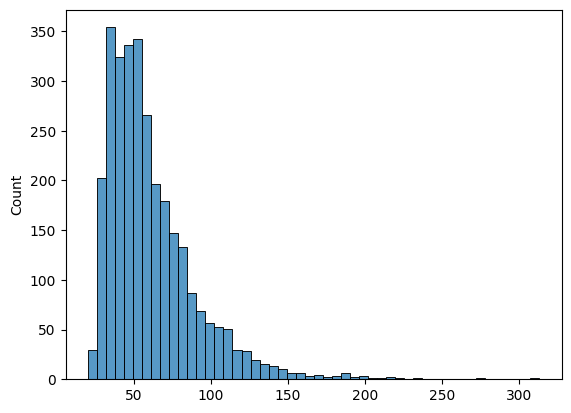

In [14]:
# read count mean per cell
cell_mean_read_count = read_counts.to_numpy().mean(axis=1)
sns.histplot(cell_mean_read_count, bins=50)

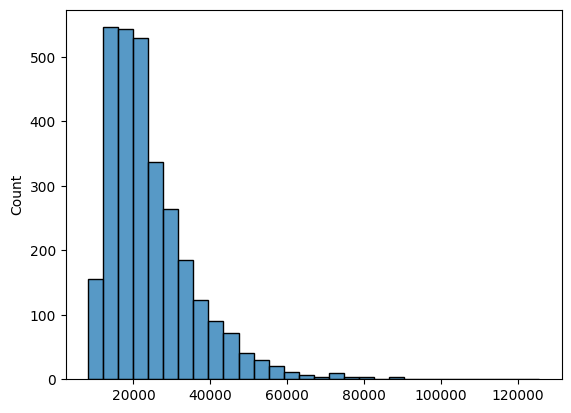

In [36]:
# total number of read per cell
sns.histplot(read_counts.sum(axis=1),bins=30)

<Axes: ylabel='Count'>

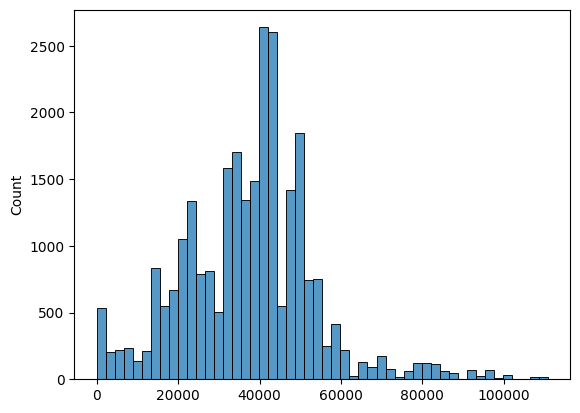

In [248]:
# total coverage per variant 
sns.histplot(covs.sum(axis=0),bins=50)

<Axes: ylabel='Count'>

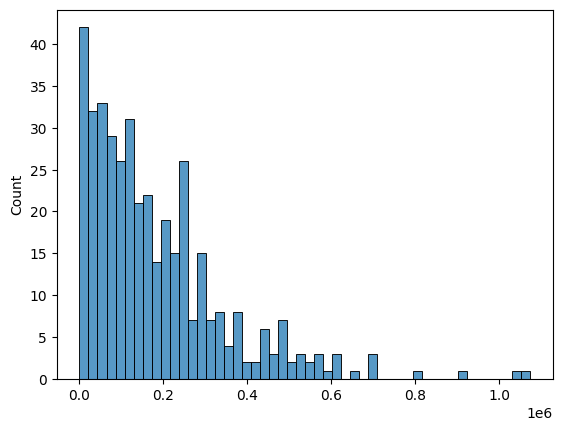

In [16]:
# total coverage per amplicon 
sns.histplot(read_counts.sum(axis=0),bins=50)

First strange thing, some variants have higher coverage than amplicon

<Axes: ylabel='Count'>

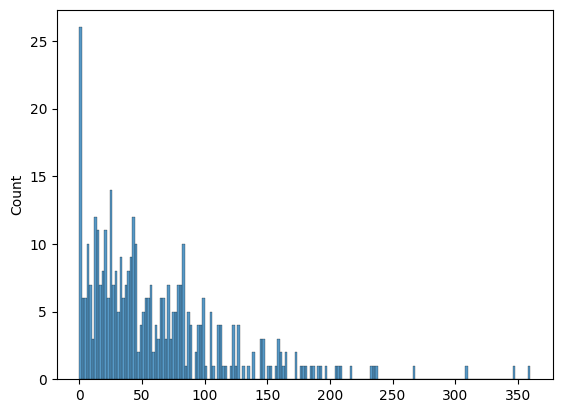

In [19]:
# mean read count per amplicon
amplicon_mean_read_count = read_counts.to_numpy().mean(axis=0)
sns.histplot(amplicon_mean_read_count, bins=10, binwidth=2)

<Axes: ylabel='Count'>

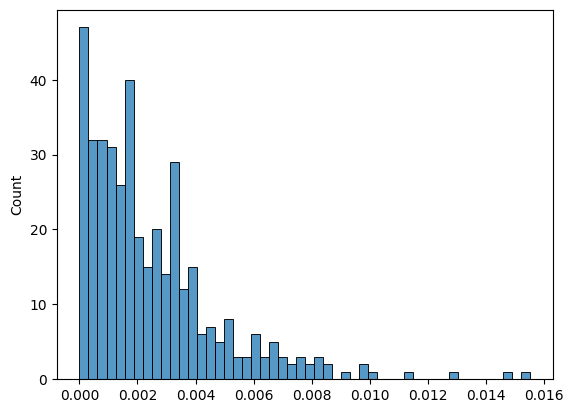

In [18]:
# amplicon mean prob (after normalization), different behavior 
sns.histplot(read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).to_numpy().mean(axis=0), bins=50)

### normalization impact

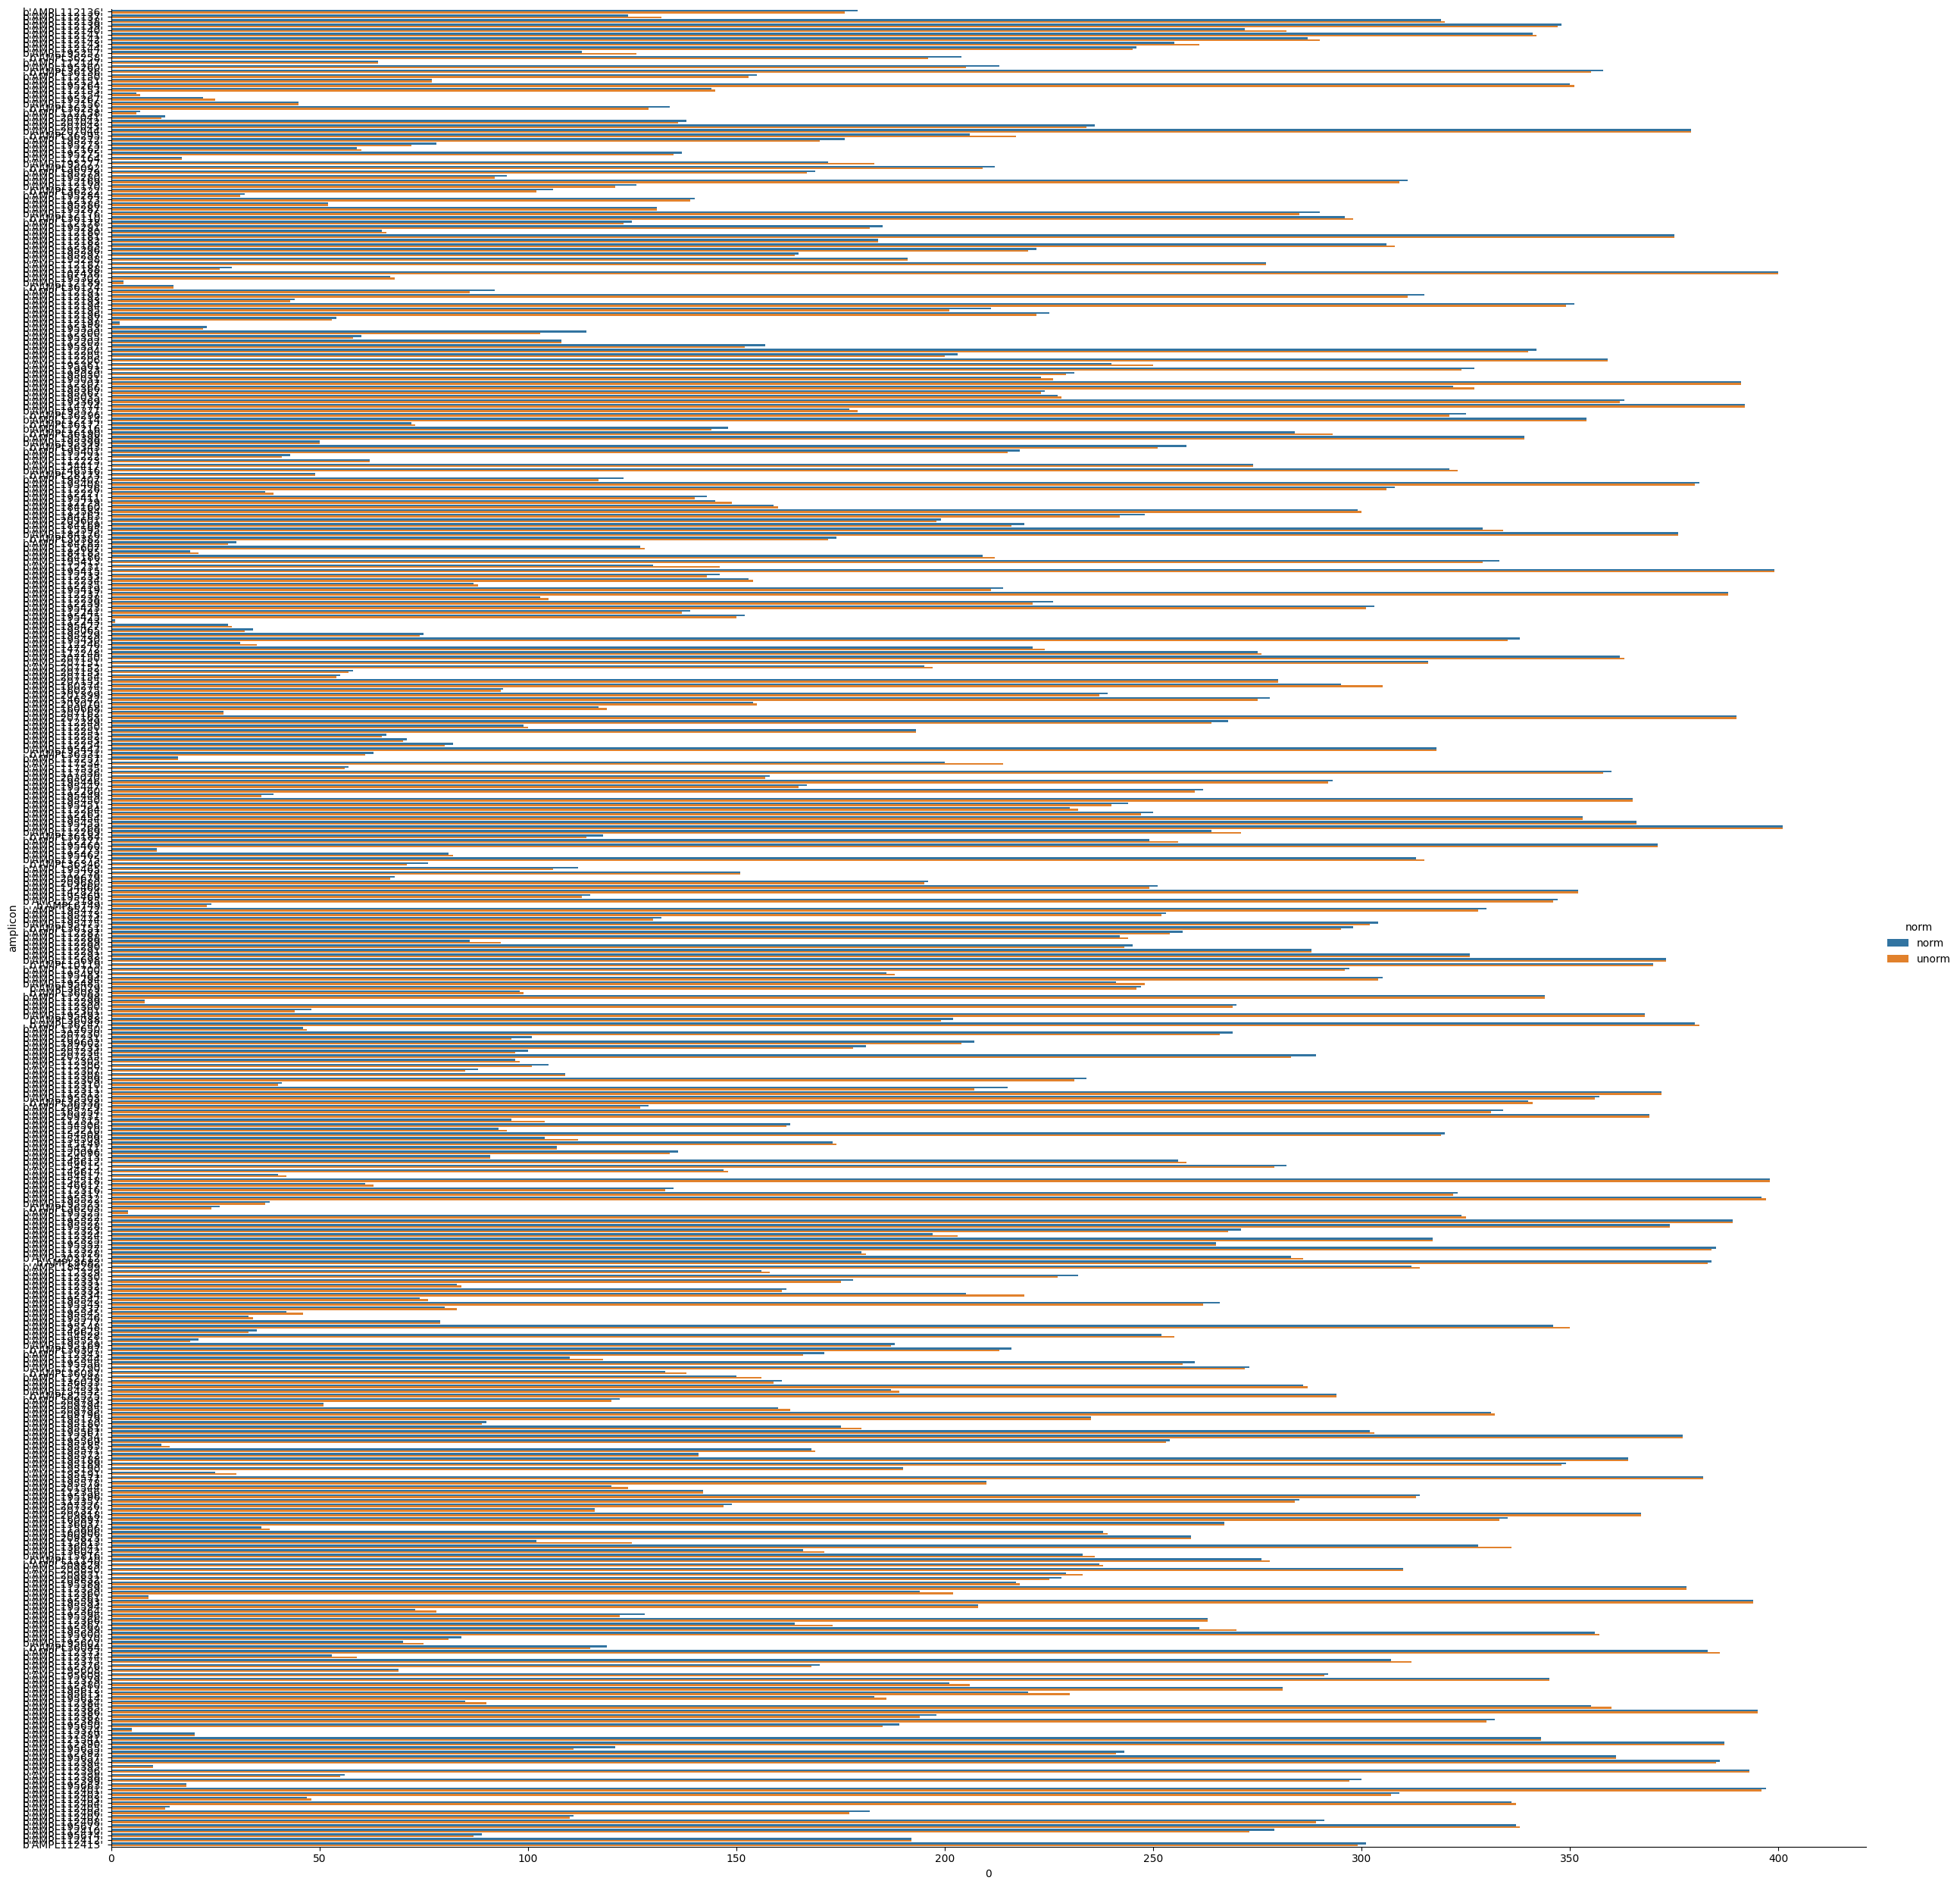

In [23]:

# RANK by mean read count before and after normalization

with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0).rank(ascending=False).values
,'unorm_rank': read_counts.mean(axis=0).rank(ascending=False).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(401)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index
sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=25
)

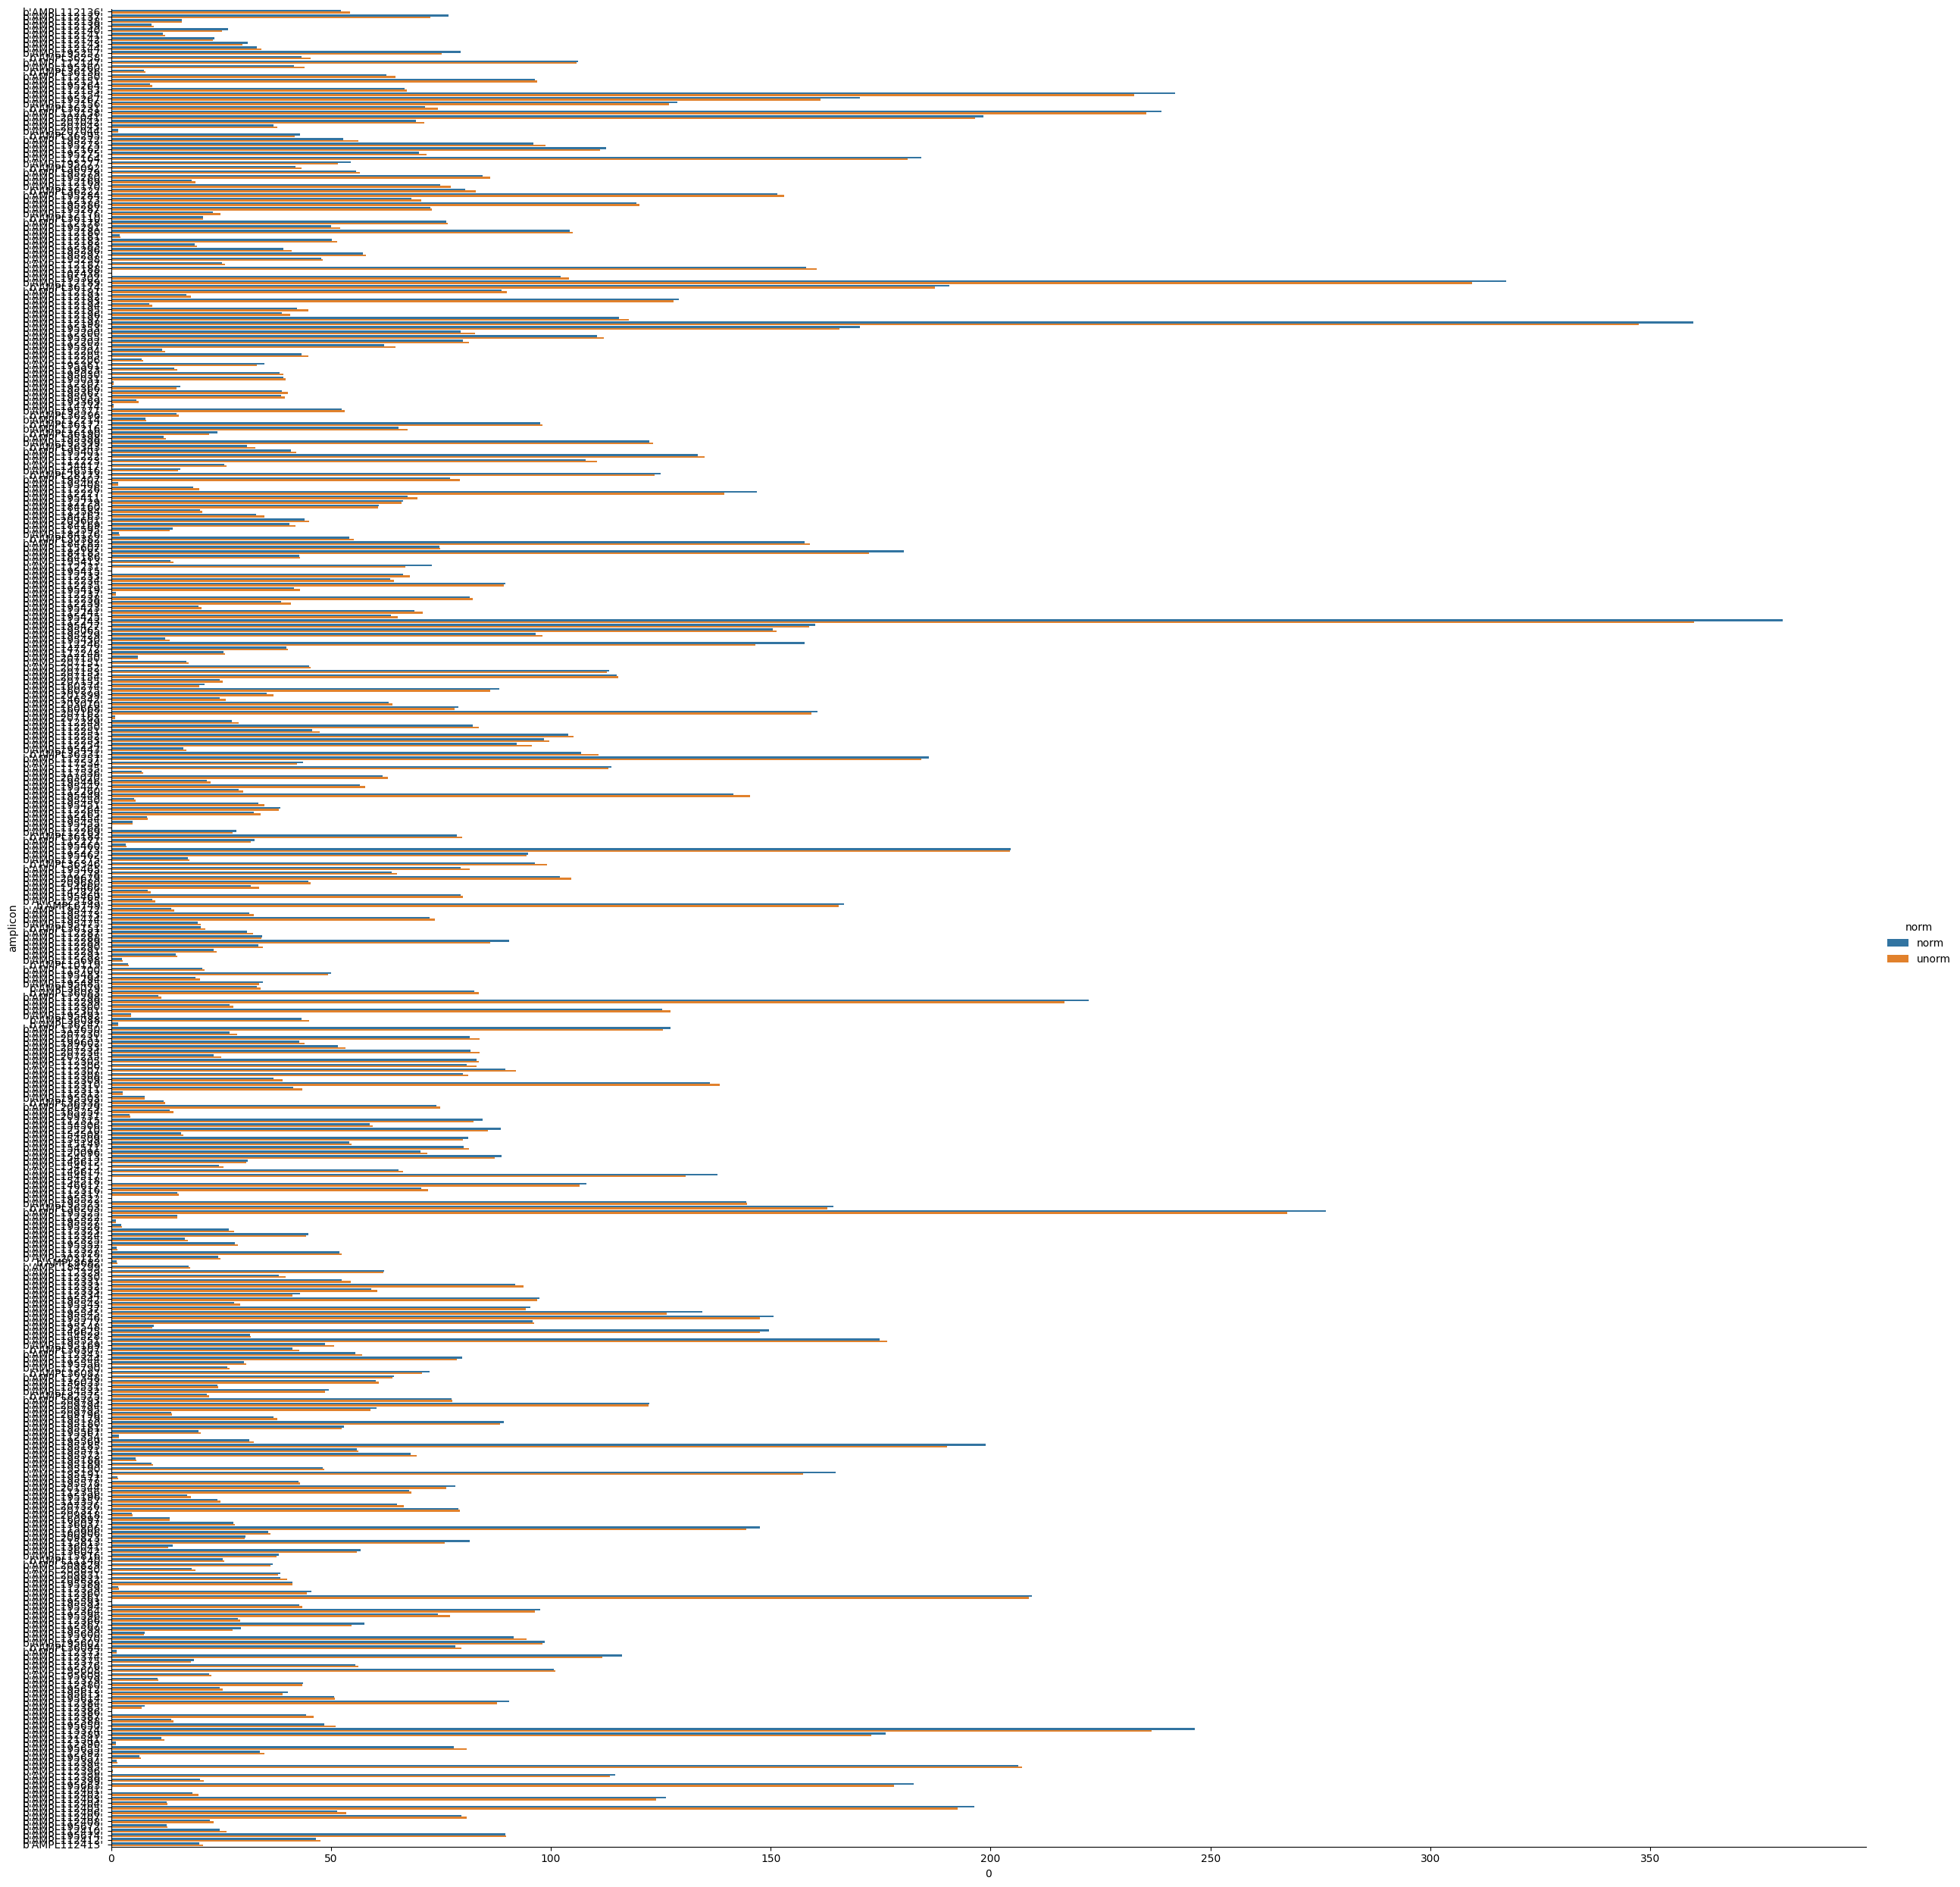

In [24]:
# mean Normalized read count, new read count (prop*mean tot read count cell)

mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0)*mean_tot_nb_read_cell).values
,'unorm_rank': read_counts.mean(axis=0).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(401)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index

sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=25
)

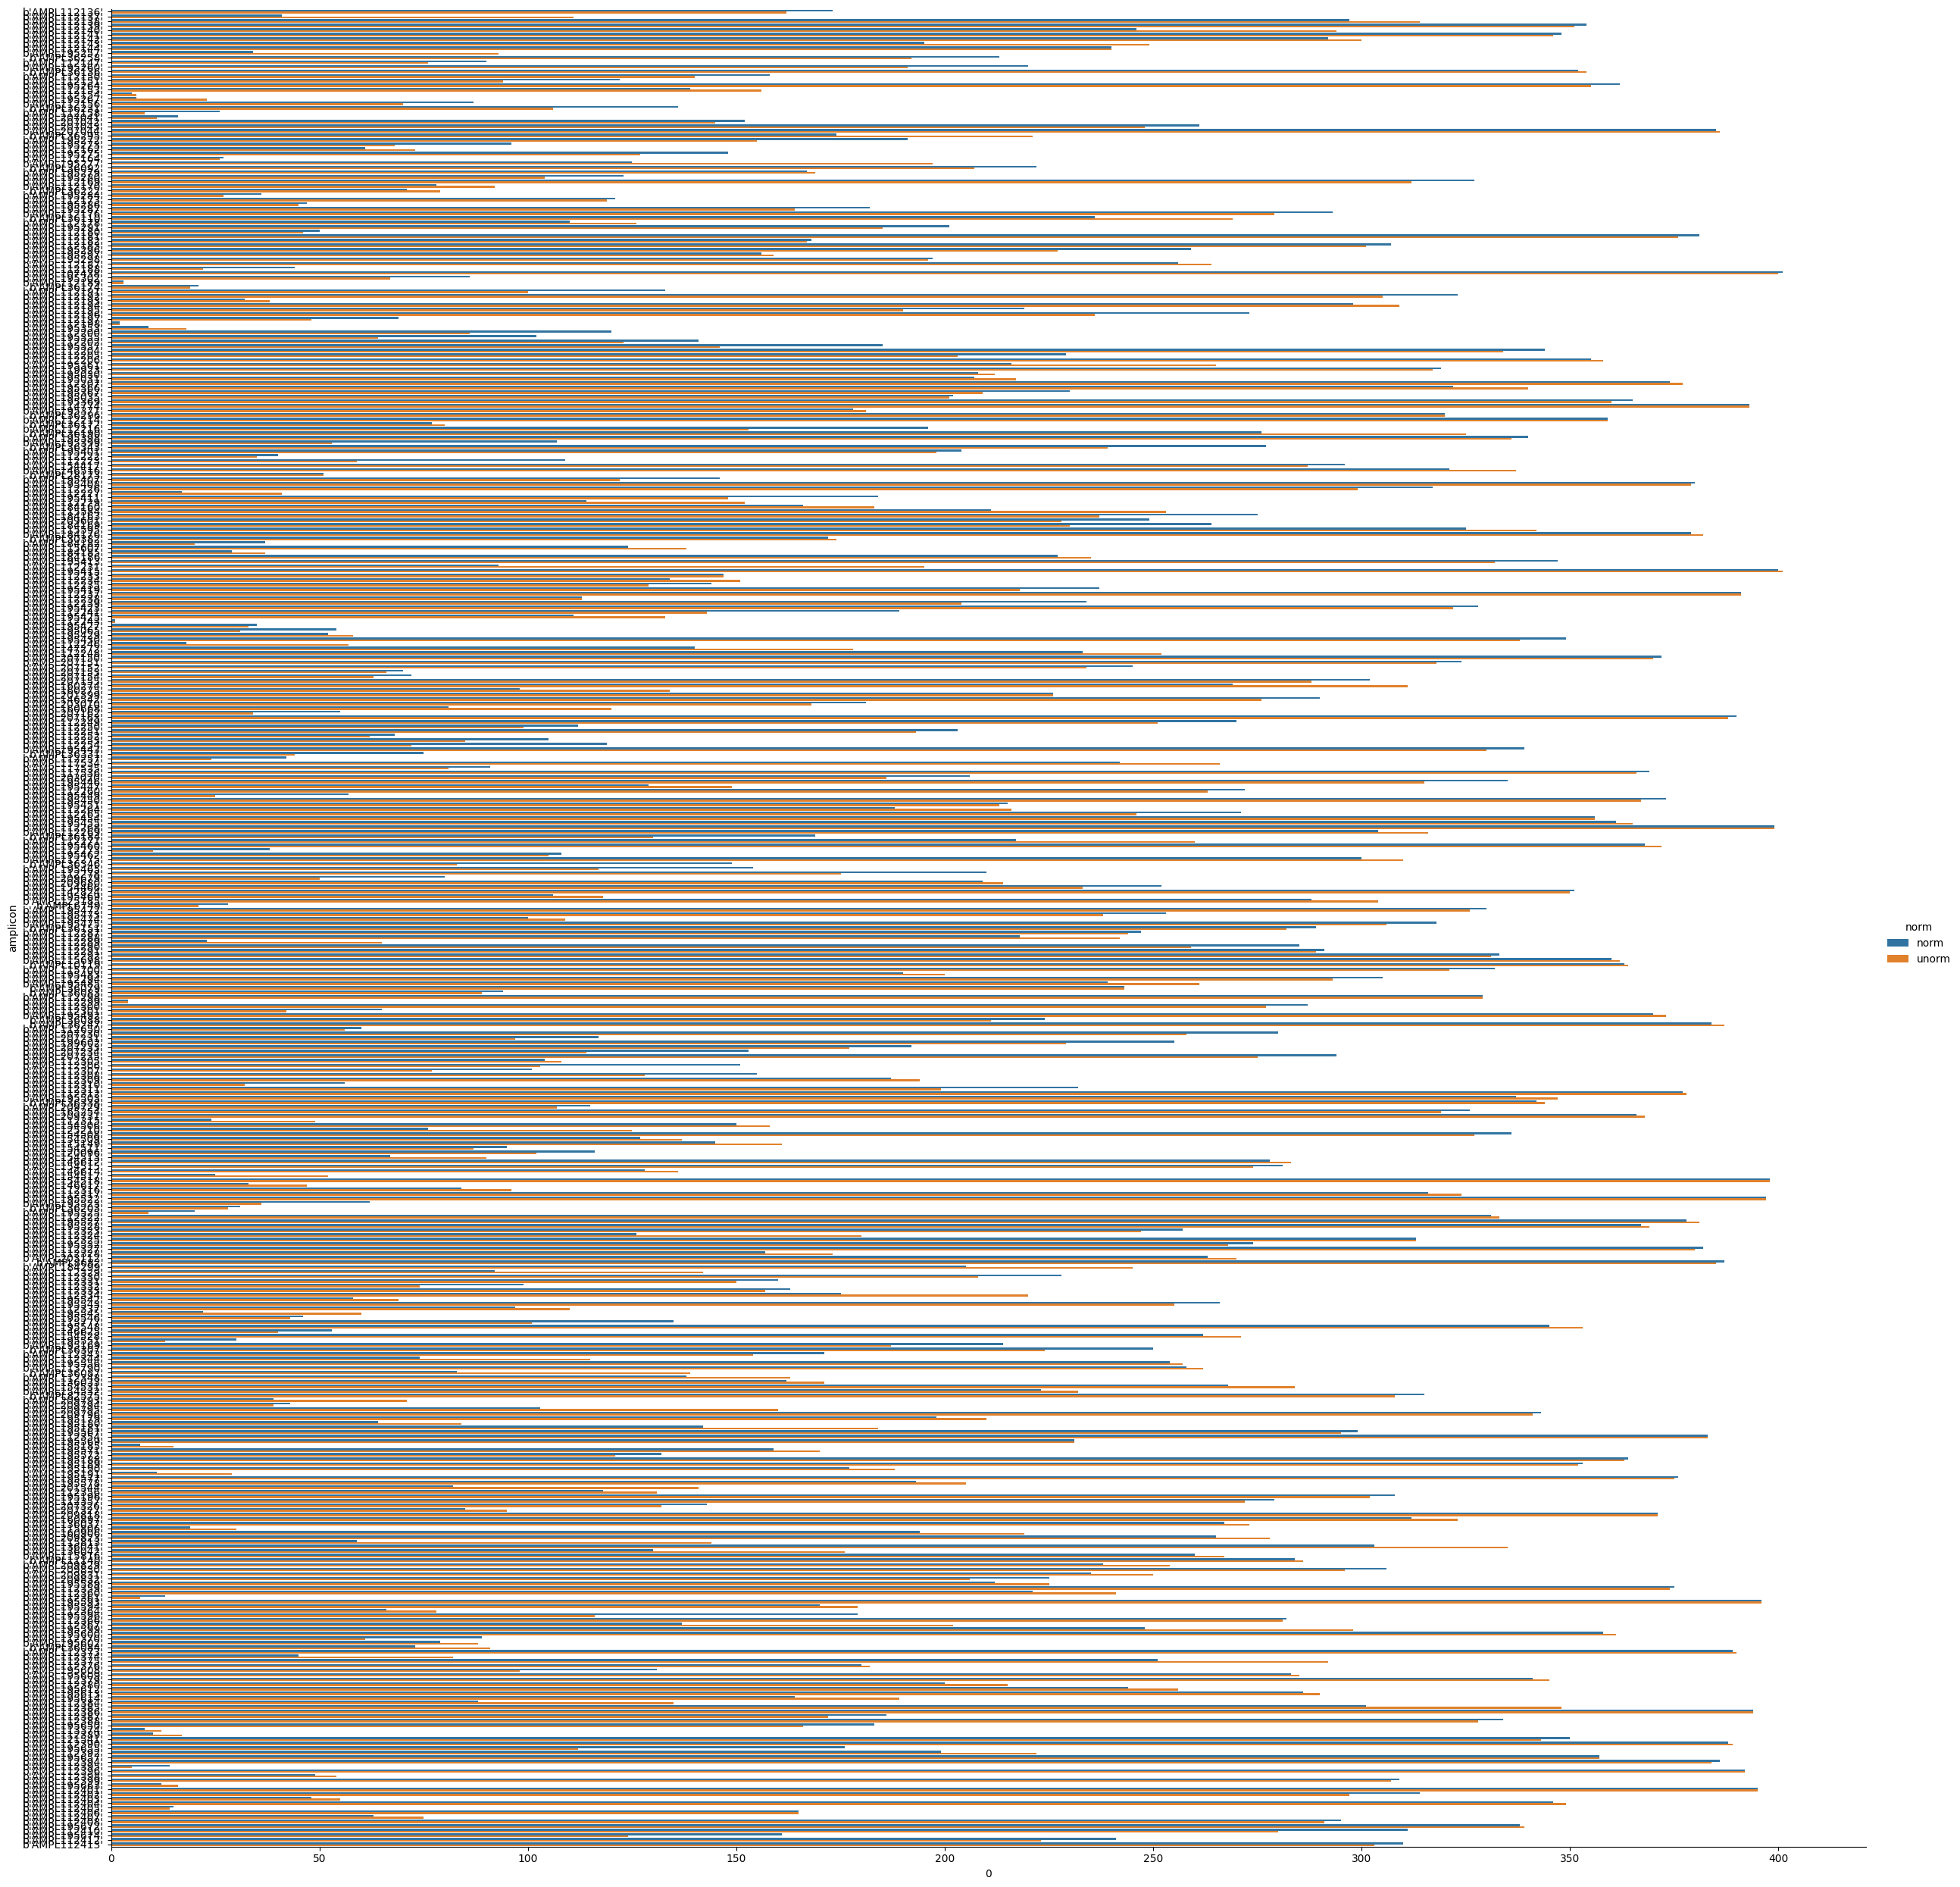

In [25]:

# RANK by variance before and after normalization

with_without_norm_read_rank = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).std(axis=0).rank(ascending=False).values
,'unorm_rank': read_counts.std(axis=0).rank(ascending=False).values})
with_without_norm_read_rank = with_without_norm_read_rank.set_index('amplicon').stack().reset_index(level=1,drop=True).to_frame()
with_without_norm_read_rank['norm'] = np.array([['norm','unorm'] for _ in range(401)]).flatten()
with_without_norm_read_rank['amplicon'] = with_without_norm_read_rank.index
sns.catplot(
    data=with_without_norm_read_rank, kind="bar",
    x=0, y="amplicon", hue="norm", alpha=1, height=25
)

<Axes: ylabel='Count'>

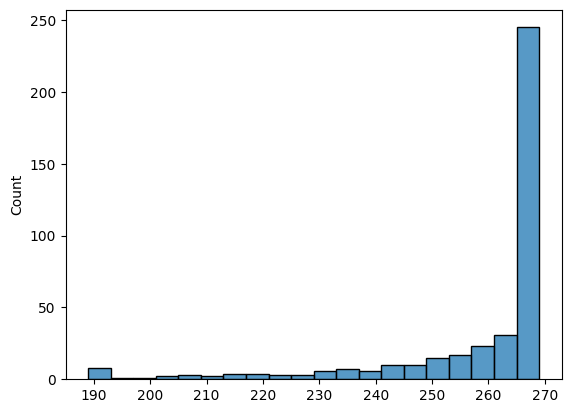

In [26]:
# variance of size of amplicon

sns.histplot(amplicons.end_pos - amplicons.start_pos, bins=20)

<Axes: xlabel='length', ylabel='CHROM'>

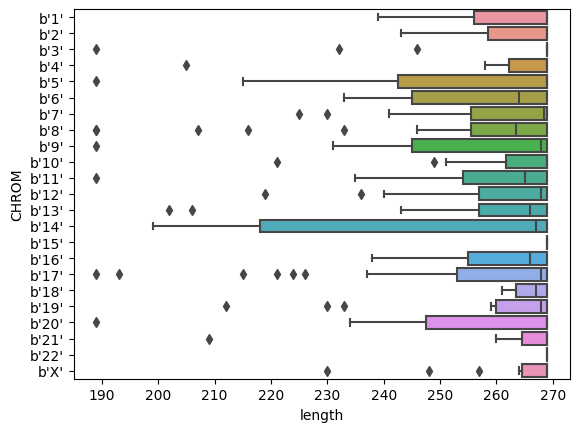

In [27]:
# amplicon size variance in chromosome
sanity_amplicon = amplicons.copy()
sanity_amplicon['length'] = sanity_amplicon.end_pos - sanity_amplicon.start_pos
sanity_amplicon[['CHROM','length']].groupby(['CHROM']).mean()
sns.boxplot(data=sanity_amplicon, x='length',y='CHROM')

In [28]:
# number of amplicon per chomosome
sanity_amplicon.groupby(['CHROM']).count()

end_pos  id  r1_counts  r2_counts  start_pos  length
CHROM                                                      
b'1'        33  33         33         33         33      33
b'10'       20  20         20         20         20      20
b'11'       18  18         18         18         18      18
b'12'       21  21         21         21         21      21
b'13'       21  21         21         21         21      21
b'14'       15  15         15         15         15      15
b'15'        5   5          5          5          5       5
b'16'       13  13         13         13         13      13
b'17'       54  54         54         54         54      54
b'18'        6   6          6          6          6       6
b'19'       14  14         14         14         14      14
b'2'        15  15         15         15         15      15
b'20'        7   7          7          7          7       7
b'21'        7   7          7          7          7       7
b'22'        6   6          6          6          6       6
b'3'        13  13         13         13         13      13
b'4'        10  10         10         10         10      10
b'5'        19  19         19         19         19      19
b'6'        13  13         13         13         13      13
b'7'        36  36         36         36         36      36
b'8'        30  30         30         30         30      30
b'9'        11  11         11         11         11      11
b'X'        14  14         14         14         14      14

<Axes: xlabel='length', ylabel='r1_counts'>

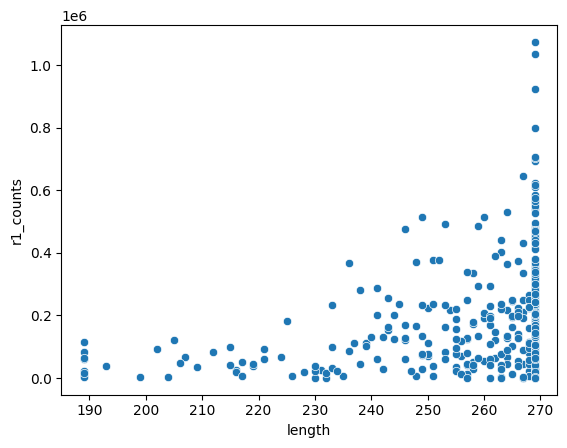

In [29]:
# link between size of amplicon and total read count
sns.scatterplot(data=sanity_amplicon,x='length',y='r1_counts')

### sanity check read count and cov

Do we have the variant with the max nb of read count accross cells <= total read count of the amplicon it belongs to ? 
and for a given amplicon if we compute the max of its variant read count for each cell and sum == total read count of the amplicon


In [228]:
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # variant with max read per amplicon
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  r1_counts  r2_counts
amplicon                                              
b'AML_v2_ASXL1_30956774'   96748      53141      53111
b'AML_v2_ASXL1_31015840'   94131      53753      53732
b'AML_v2_ASXL1_31021160'   82671      43869      43155
b'AML_v2_ASXL1_31021460'   45419      22622      23268
b'AML_v2_ASXL1_31022192'   70378      36757      36710
...                          ...        ...        ...
b'AML_v2_WT1_32413452'     57089      28945      28925
b'AML_v2_WT1_32414209'     79400      41840      41799
b'AML_v2_WT1_32417780'     77764      40601      40580
b'AML_v2_WT1_32421532'    107474      65205      65175
b'AML_v2_WT1_32439105'    110845      69072      69013

[127 rows x 3 columns]

In [239]:
# after filtering variants
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv.iloc[variants[variants.filtered == 1].index]
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants[variants.filtered == 1].amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # variant with max read per amplicon not sum
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  r1_counts  r2_counts
amplicon                                              
b'AML_v2_ASXL1_30956774'   96748      53141      53111
b'AML_v2_ASXL1_31015840'   94131      53753      53732
b'AML_v2_ASXL1_31021160'   82671      43869      43155
b'AML_v2_ASXL1_31021460'   45419      22622      23268
b'AML_v2_ASXL1_31022192'   70378      36757      36710
...                          ...        ...        ...
b'AML_v2_WT1_32413452'     57089      28945      28925
b'AML_v2_WT1_32414209'     79400      41840      41799
b'AML_v2_WT1_32417780'     77764      40601      40580
b'AML_v2_WT1_32421532'    107474      65205      65175
b'AML_v2_WT1_32439105'    110845      69072      69013

[127 rows x 3 columns]

In [105]:
filtermask[filtermask ==0] =2 
filtermask[filtermask == 1] = 0
filtermask/2

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'                    0.0                    1.0  \
b'AACAACCTATCTATGACA-1'                    0.0                    1.0   
b'AACAACTGGCAACGCACA-1'                    1.0                    1.0   
b'AACACACTCTTACAGTGT-1'                    1.0                    1.0   
b'AACAGCAGTCGTCTGCTG-1'                    1.0                    1.0   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                    0.0                    1.0   
b'TTGGAGAACTGAACTTGC-1'                    1.0                    1.0   
b'TTGGTAACTTCTGCGCTG-1'                    1.0                    1.0   
b'TTGTCAACCGCAGCAGTG-1'                    1.0                    1.0   
b'TTGTTAGAGAATCTCCTA-1'                    0.0                    1.0   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'                    1.0                   1.0  \
b'AACAACCTATCTATGACA-1'                    1.0                   1.0   
b'AACAACTGGCAACGCACA-1'                    1.0                   1.0   
b'AACACACTCTTACAGTGT-1'                    1.0                   1.0   
b'AACAGCAGTCGTCTGCTG-1'                    1.0                   1.0   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'                    1.0                   1.0   
b'TTGGAGAACTGAACTTGC-1'                    1.0                   1.0   
b'TTGGTAACTTCTGCGCTG-1'                    1.0                   1.0   
b'TTGTCAACCGCAGCAGTG-1'                    1.0                   1.0   
b'TTGTTAGAGAATCTCCTA-1'                    1.0                   1.0   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'                    1.0                    1.0  \
b'AACAACCTATCTATGACA-1'                    1.0                    1.0   
b'AACAACTGGCAACGCACA-1'                    1.0                    1.0   
b'AACACACTCTTACAGTGT-1'                    1.0                    1.0   
b'AACAGCAGTCGTCTGCTG-1'                    1.0                    1.0   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                    1.0                    1.0   
b'TTGGAGAACTGAACTTGC-1'                    1.0                    1.0   
b'TTGGTAACTTCTGCGCTG-1'                    1.0                    1.0   
b'TTGTCAACCGCAGCAGTG-1'                    1.0                    1.0   
b'TTGTTAGAGAATCTCCTA-1'                    1.0                    1.0   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                   1.0                    1.0  \
b'AACAACCTATCTATGACA-1'                   1.0                    1.0   
b'AACAACTGGCAACGCACA-1'                   1.0                    1.0   
b'AACACACTCTTACAGTGT-1'                   1.0                    1.0   
b'AACAGCAGTCGTCTGCTG-1'                   1.0                    1.0   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                   1.0                    1.0   
b'TTGGAGAACTGAACTTGC-1'                   1.0                    1.0   
b'TTGGTAACTTCTGCGCTG-1'                   1.0                    1.0   
b'TTGTCAACCGCAGCAGTG-1'                   1.0                    1.0   
b'TTGTTAGAGAATCTCCTA-1'                   1.0                    1.0   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'                    1.0                   1.0  ...  \
b'AACAACCTATCTATGACA-1'                    1.0                   1.0  ...   
b'AACAACTGGCAACGCACA-1'                    1.0                   1.0  ...   
b'AACACACTCTTACAGTGT-1'                    1.0                   1.0  ...   
b'AACAGCAGTCGTCTGCTG-1'                    1.0                   1.0  ...   
...                                        ...                   ...  ...   
b'

In [111]:
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv*(filtermask/2).T

sanity_snv

b'AACAACCTACAGAAGTGA-1'  b'AACAACCTATCTATGACA-1'   
b'chr1:115256513:G/A'                      0.0                      0.0  \
b'chr1:115256513:G/T'                     36.0                      9.0   
b'chr1:115256514:G/A'                     36.0                     11.0   
b'chr1:115256515:C/'                      36.0                     11.0   
b'chr1:115256516:A/G'                     36.0                     11.0   
...                                        ...                      ...   
b'chr21:44524605:T/C'                     30.0                     26.0   
b'chr21:44524606:T/C'                     30.0                     26.0   
b'chr21:44524607:A/'                      30.0                     26.0   
b'chr21:44524608:A/G'                     28.0                     26.0   
b'chr21:44524609:C/'                      30.0                     26.0   

                       b'AACAACTGGCAACGCACA-1'  b'AACACACTCTTACAGTGT-1'   
b'chr1:115256513:G/A'                     43.0                     51.0  \
b'chr1:115256513:G/T'                     43.0                     51.0   
b'chr1:115256514:G/A'                     43.0                     51.0   
b'chr1:115256515:C/'                      43.0                     51.0   
b'chr1:115256516:A/G'                     43.0                     51.0   
...                                        ...                      ...   
b'chr21:44524605:T/C'                     26.0                     46.0   
b'chr21:44524606:T/C'                     26.0                     46.0   
b'chr21:44524607:A/'                      26.0                     46.0   
b'chr21:44524608:A/G'                     26.0                     46.0   
b'chr21:44524609:C/'                      26.0                     46.0   

                       b'AACAGCAGTCGTCTGCTG-1'  b'AACAGCAGTGATGCTCCT-1'   
b'chr1:115256513:G/A'                     31.0                     54.0  \
b'chr1:115256513:G/T'                     31.0                     54.0   
b'chr1:115256514:G/A'                     31.0                     54.0   
b'chr1:115256515:C/'                      31.0                     54.0   
b'chr1:115256516:A/G'                     31.0                     54.0   
...                                        ...                      ...   
b'chr21:44524605:T/C'                     40.0                     49.0   
b'chr21:44524606:T/C'                     40.0                     49.0   
b'chr21:44524607:A/'                      40.0                     49.0   
b'chr21:44524608:A/G'                     40.0                     49.0   
b'chr21:44524609:C/'                      40.0                     49.0   

                       b'AACCGCTGAAACAACCTA-1'  b'AACCGCTGAACCACGCTA-1'   
b'chr1:115256513:G/A'                     21.0                     36.0  \
b'chr1:115256513:G/T'                     21.0                     36.0   
b'chr1:115256514:G/A'                     21.0                     36.0   
b'chr1:115256515:C/'                      21.0                     36.0   
b'chr1:115256516:A/G'                     21.0                     36.0   
...                                        ...                      ...   
b'chr21:44524605:T/C'                     19.0                     33.0   
b'chr21:44524606:T/C'                     19.0                     33.0   
b'chr21:44524607:A/'                      19.0                     33.0   
b'chr21:44524608:A/G'                     19.0                     33.0   
b'chr21:44524609:C/'                      19.0                     33.0   

                       b'AACGCATTGCGTTAATGG-1'  b'AACGCCTACACCATACTT-1'  ...   
b'chr1:115256513:G/A'                     34.0                      0.0  ...  \
b'chr1:115256513:G/T'                     34.0                     51.0  ...   
b'chr1:115256514:G/A'                     34.0                     51.0  ...   
b'chr1:115256515:C/'                      34.0                     51.0  ...   
b'chr1:115256516:A/

In [114]:
# after filtering variants and cells 
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv*(filtermask/2).T
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # variant with max read per amplicon not sum
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  r1_counts  r2_counts
amplicon                                                
b'AML_v2_ASXL1_30956774'   96748.0      53141      53111
b'AML_v2_ASXL1_31015840'   94131.0      53753      53732
b'AML_v2_ASXL1_31021160'   82671.0      43869      43155
b'AML_v2_ASXL1_31021460'   45419.0      22622      23268
b'AML_v2_ASXL1_31022192'   70378.0      36757      36710
...                            ...        ...        ...
b'AML_v2_WT1_32413452'     57089.0      28945      28925
b'AML_v2_WT1_32414209'     79400.0      41840      41799
b'AML_v2_WT1_32417780'     77764.0      40601      40580
b'AML_v2_WT1_32421532'    107474.0      65205      65175
b'AML_v2_WT1_32439105'    110845.0      69072      69013

[127 rows x 3 columns]

In [128]:
max_amplicon = covs.T.copy()
max_amplicon['amplicon'] = variants.amplicon.values
max_amplicon = max_amplicon.groupby('amplicon').max()
max_amplicon = max_amplicon.T

# after filtering variants and cells 
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv*(filtermask/2).T
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').max() # variant with max read per amplicon not sum
sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv['max'] = max_amplicon.sum()
sanity_snv

sum  r1_counts  r2_counts     max
amplicon                                                        
b'AML_v2_ASXL1_30956774'   96748.0      53141      53111   97053
b'AML_v2_ASXL1_31015840'   94131.0      53753      53732   94397
b'AML_v2_ASXL1_31021160'   82671.0      43869      43155   83015
b'AML_v2_ASXL1_31021460'   45419.0      22622      23268   45528
b'AML_v2_ASXL1_31022192'   70378.0      36757      36710   70526
...                            ...        ...        ...     ...
b'AML_v2_WT1_32413452'     57089.0      28945      28925   57287
b'AML_v2_WT1_32414209'     79400.0      41840      41799   79580
b'AML_v2_WT1_32417780'     77764.0      40601      40580   77966
b'AML_v2_WT1_32421532'    107474.0      65205      65175  107863
b'AML_v2_WT1_32439105'    110845.0      69072      69013  111084

[127 rows x 4 columns]

In [117]:
# total read count snv of amplicon after filtering
sanity_snv = covs.T.copy()
sanity_snv = sanity_snv*(filtermask/2).T
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts # nb of variant per amplicon
sanity_snv['per_snv'] = sanity_snv['sum']/sanity_snv['count'] # mean variant read per amplicon
sanity_snv['median_var'] = median_var # median variant read per amplicon

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  count       per_snv  median_var   
amplicon                                                                
b'AML_v2_ASXL1_30956774'  11193265.0    196  57108.494898     48934.0  \
b'AML_v2_ASXL1_31015840'  10736037.0    210  51123.985714     47677.5   
b'AML_v2_ASXL1_31021160'  10078496.0    215  46876.725581     41229.0   
b'AML_v2_ASXL1_31021460'   4989780.0    185  26971.783784     23058.0   
b'AML_v2_ASXL1_31022192'   8221341.0    228  36058.513158     35451.5   
...                              ...    ...           ...         ...   
b'AML_v2_WT1_32413452'     6440547.0    174  37014.637931     28626.5   
b'AML_v2_WT1_32414209'     9163913.0    196  46754.658163     39851.0   
b'AML_v2_WT1_32417780'     8834845.0    204  43308.063725     39056.0   
b'AML_v2_WT1_32421532'    13338123.0    230  57991.839130     54543.0   
b'AML_v2_WT1_32439105'    13498564.0    225  59993.617778     56759.0   

                          r1_counts  r2_counts  
amplicon                                        
b'AML_v2_ASXL1_30956774'      53141      53111  
b'AML_v2_ASXL1_31015840'      53753      53732  
b'AML_v2_ASXL1_31021160'      43869      43155  
b'AML_v2_ASXL1_31021460'      22622      23268  
b'AML_v2_ASXL1_31022192'      36757      36710  
...                             ...        ...  
b'AML_v2_WT1_32413452'        28945      28925  
b'AML_v2_WT1_32414209'        41840      41799  
b'AML_v2_WT1_32417780'        40601      40580  
b'AML_v2_WT1_32421532'        65205      65175  
b'AML_v2_WT1_32439105'        69072      69013  

[127 rows x 6 columns]

In [187]:
# total read count snv of amplicon
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts # nb of variant per amplicon
sanity_snv['per_snv'] = sanity_snv['sum']/sanity_snv['count'] # mean variant read per amplicon
sanity_snv['median_var'] = median_var # median variant read per amplicon

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  count       per_snv  median_var   
amplicon                                                              
b'AML_v2_ASXL1_30956774'  11193265    196  57108.494898     48934.0  \
b'AML_v2_ASXL1_31015840'  10736037    210  51123.985714     47677.5   
b'AML_v2_ASXL1_31021160'  10078496    215  46876.725581     41229.0   
b'AML_v2_ASXL1_31021460'   5008863    185  27074.935135     23058.0   
b'AML_v2_ASXL1_31022192'   8233281    228  36110.881579     35451.5   
...                            ...    ...           ...         ...   
b'AML_v2_WT1_32413452'     6440547    174  37014.637931     28626.5   
b'AML_v2_WT1_32414209'     9164606    196  46758.193878     39851.0   
b'AML_v2_WT1_32417780'     8834845    204  43308.063725     39056.0   
b'AML_v2_WT1_32421532'    13341651    230  58007.178261     54543.0   
b'AML_v2_WT1_32439105'    13526610    225  60118.266667     56759.0   

                          r1_counts  r2_counts  
amplicon                                        
b'AML_v2_ASXL1_30956774'      53141      53111  
b'AML_v2_ASXL1_31015840'      53753      53732  
b'AML_v2_ASXL1_31021160'      43869      43155  
b'AML_v2_ASXL1_31021460'      22622      23268  
b'AML_v2_ASXL1_31022192'      36757      36710  
...                             ...        ...  
b'AML_v2_WT1_32413452'        28945      28925  
b'AML_v2_WT1_32414209'        41840      41799  
b'AML_v2_WT1_32417780'        40601      40580  
b'AML_v2_WT1_32421532'        65205      65175  
b'AML_v2_WT1_32439105'        69072      69013  

[127 rows x 6 columns]

In [254]:
# useless
# total read count snv of amplicon, different pos snv 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
sanity_snv['POS'] = variants.POS.values
sanity_snv = sanity_snv.drop_duplicates('POS')
counts = sanity_snv[['sum','amplicon']].groupby(['amplicon']).count().values
median_var = sanity_snv[['sum','amplicon']].groupby(['amplicon']).median()
sanity_snv = sanity_snv[['sum','amplicon']].groupby('amplicon').sum()
sanity_snv['count'] = counts
sanity_snv['per_snv'] = sanity_snv['sum']/sanity_snv['count'] # mean 
sanity_snv['median_var'] = median_var

sanity_snv = sanity_snv.join(amplicons[['r1_counts','r2_counts','id']].set_index('id'), on='amplicon')
sanity_snv

sum  count       per_snv  median_var   
amplicon                                                              
b'AML_v2_ASXL1_30956774'  10027490    173  57962.369942     48938.0  \
b'AML_v2_ASXL1_31015840'   9690454    189  51272.243386     47676.0   
b'AML_v2_ASXL1_31021160'   8669995    185  46864.837838     41227.0   
b'AML_v2_ASXL1_31021460'   4711682    174  27078.632184     23058.0   
b'AML_v2_ASXL1_31022192'   7383531    204  36193.779412     35450.5   
...                            ...    ...           ...         ...   
b'AML_v2_WT1_32413452'     5812236    156  37257.923077     28627.5   
b'AML_v2_WT1_32414209'     8129307    172  47263.412791     39854.5   
b'AML_v2_WT1_32417780'     8092142    185  43741.308108     39056.0   
b'AML_v2_WT1_32421532'    11392642    196  58125.724490     54543.0   
b'AML_v2_WT1_32439105'    11618232    193  60198.093264     56756.0   

                          r1_counts  r2_counts  
amplicon                                        
b'AML_v2_ASXL1_30956774'      53141      53111  
b'AML_v2_ASXL1_31015840'      53753      53732  
b'AML_v2_ASXL1_31021160'      43869      43155  
b'AML_v2_ASXL1_31021460'      22622      23268  
b'AML_v2_ASXL1_31022192'      36757      36710  
...                             ...        ...  
b'AML_v2_WT1_32413452'        28945      28925  
b'AML_v2_WT1_32414209'        41840      41799  
b'AML_v2_WT1_32417780'        40601      40580  
b'AML_v2_WT1_32421532'        65205      65175  
b'AML_v2_WT1_32439105'        69072      69013  

[127 rows x 6 columns]

<Axes: xlabel='count', ylabel='Count'>

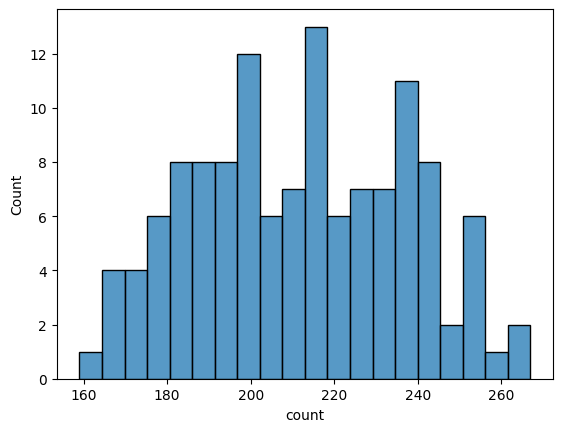

In [138]:
# nb of variant per amplicon
sns.histplot(sanity_snv['count'], bins=20)

In [30]:
# link between size of amplicon and nb variant
sanity_snv['length'] = (amplicons.end_pos - amplicons.start_pos).values
sns.scatterplot(data=sanity_snv,x='length',y='count')

NameError: name 'sanity_snv' is not defined

In [85]:
# total num of read per variant 
sanity_snv = covs.T.copy()
sanity_snv['sum'] = sanity_snv.sum(axis=1).values
sanity_snv['amplicon'] = variants.amplicon.values
snv_amplicon_read = sanity_snv[['sum','amplicon']]
snv_amplicon_read

sum                  amplicon
b'chr1:115256513:G/A'  40179  b'AML_v2_NRAS_115256512'
b'chr1:115256513:G/T'  40179  b'AML_v2_NRAS_115256512'
b'chr1:115256514:G/A'  40412  b'AML_v2_NRAS_115256512'
b'chr1:115256515:C/'   40424  b'AML_v2_NRAS_115256512'
b'chr1:115256516:A/G'  40426  b'AML_v2_NRAS_115256512'
...                      ...                       ...
b'chr21:44524605:T/C'  40950  b'AML_v2_U2AF1_44524438'
b'chr21:44524606:T/C'  40954  b'AML_v2_U2AF1_44524438'
b'chr21:44524607:A/'   40958  b'AML_v2_U2AF1_44524438'
b'chr21:44524608:A/G'  40959  b'AML_v2_U2AF1_44524438'
b'chr21:44524609:C/'   40957  b'AML_v2_U2AF1_44524438'

[26910 rows x 2 columns]

In [31]:
ranking_amplicon = pd.DataFrame({'amplicon': amplicons.id, 'norm_rank': read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0).mean(axis=0).rank(ascending=False).values
,'unorm_rank': read_counts.mean(axis=0).rank(ascending=False).values})
top10 = ranking_amplicon.sort_values(by='norm_rank').iloc[:10].amplicon.values
top20 = ranking_amplicon.sort_values(by='norm_rank').iloc[:20].amplicon.values

In [32]:
# histogram of number of read of variant in each amplicon 


# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm')

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(snv_amplicon_read[snv_amplicon_read.amplicon.isin(top20)], row='amplicon' , hue='amplicon', aspect=10, height=2, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.histplot, 'sum',
      fill=True, bins=20)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.histplot, 'sum', 
      bins=20, 
      color="w")
"""g.map(sns.kdeplot, 0,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 0, 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)"""

# here we add a horizontal line for each plot
g.map(plt.axhline, y='sum',
      lw=2, clip_on=False)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'sum')

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.15)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

NameError: name 'snv_amplicon_read' is not defined

In [96]:
top20_var_amp = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).std().sort_values(ascending=False).iloc[:20].index
top20_var_amp.values

array([b'AML_v2_TET2_106157777', b'AML_v2_EZH2_148504743',
       b'AML_v2_KRAS_25378559', b'AML_v2_EZH2_148512017',
       b'AML_v2_U2AF1_44514570', b'AML_v2_TET2_106156523',
       b'AML_v2_EZH2_148529658', b'AML_v2_RUNX1_36171592',
       b'AML_v2_DNMT3A_25469945', b'AML_v2_TET2_106158049',
       b'AML_v2_FLT3_28597520', b'AML_v2_TET2_106196456',
       b'AML_v2_KRAS_25380260', b'AML_v2_TET2_106157098',
       b'AML_v2_WT1_32439105', b'AML_v2_EZH2_148543492',
       b'AML_v2_FLT3_28609594', b'AML_v2_EZH2_148544293',
       b'AML_v2_EZH2_148507427', b'AML_v2_TET2_106197355'], dtype=object)

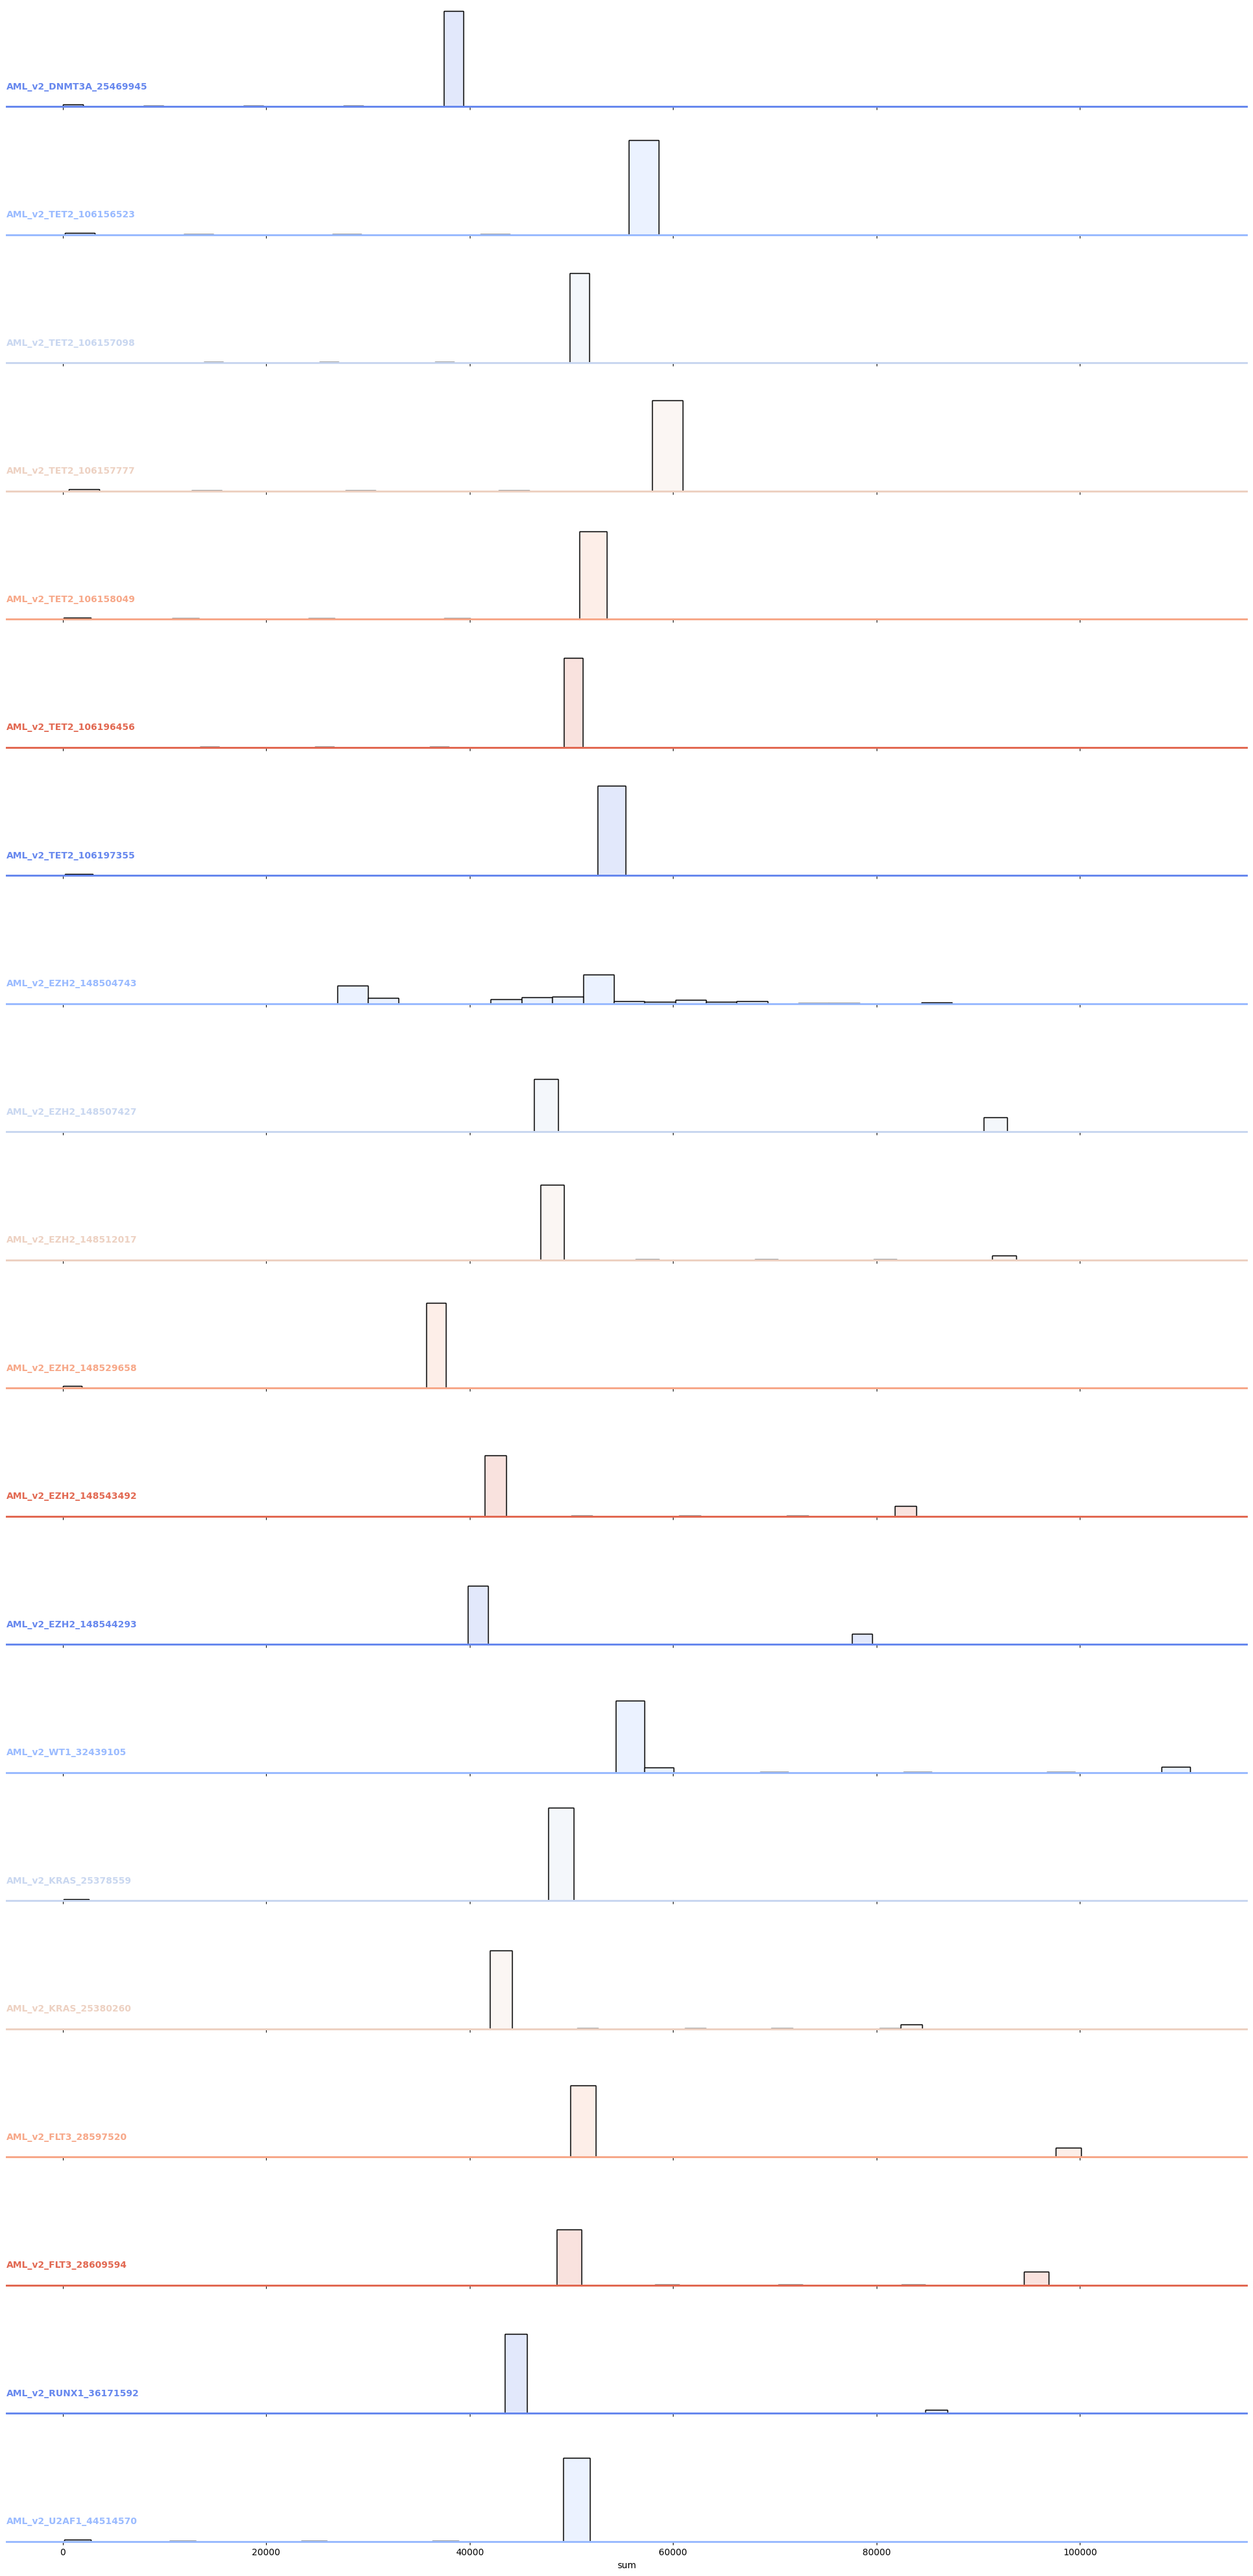

In [97]:
# histogram of number of read of variant in each amplicon top var


# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm')

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(snv_amplicon_read[snv_amplicon_read.amplicon.isin(top20_var_amp.values)], row='amplicon' , hue='amplicon', aspect=10, height=2, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.histplot, 'sum',
      fill=True, bins=20)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.histplot, 'sum', 
      bins=20, 
      color="w")
"""g.map(sns.kdeplot, 0,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 0, 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)"""

# here we add a horizontal line for each plot
g.map(plt.axhline, y='sum',
      lw=2, clip_on=False)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'sum')

# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.15)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [193]:
# nb of different pos variant (26910 in total)
variants.POS.value_counts()

POS
148508833    3
7578523      3
106154998    3
148504854    3
106154992    3
            ..
106158196    1
106158195    1
106158194    1
106158193    1
44524609     1
Name: count, Length: 24110, dtype: int64

In [191]:
variants.filtered.value_counts()

filtered
1    26866
0       44
Name: count, dtype: int64

# HEATMAP

## SNV VAF

<Axes: >

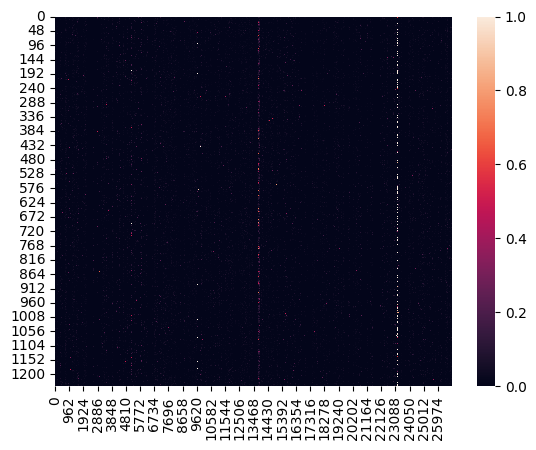

In [10]:
snv_vaf = vafs.to_numpy()
sns.heatmap(snv_vaf)

## VAFs

In [46]:
snv_read_count = vafs.copy()

for col in snv_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    snv_read_count[col] = read_counts[amplicon]

# snv_read_count replace vafs by read count of associated amplicon for each variant

In [13]:
np.unique(snv_read_count.iloc[0].values).shape # unique values (read count variant) need to be < 127

(57,)

In [15]:
np.unique(read_counts.iloc[0].values).shape # unique values (read count amplicon) (equal !)

(57,)

In [47]:
vaf_by_hand = covs/snv_read_count

values for vafs and vafs by hand and vafs corrected

In [277]:
np.unique(vaf_by_hand.round(decimals=1).values) # > 1 

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 3. , 3.5, 4. , 5. , 6. , inf, nan])

In [278]:
np.unique(vafs.round(decimals=1).values)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [36]:
max_amplicon = covs.T.copy()
max_amplicon['amplicon'] = variants.amplicon.values
max_amplicon = max_amplicon.groupby('amplicon').max()
max_amplicon = max_amplicon.T
max_amplicon # max variant read count for each amplicon and cell (actual read count ?)

amplicon                 b'AML_v2_ASXL1_30956774'  b'AML_v2_ASXL1_31015840'   
b'AACAACCTACAGAAGTGA-1'                        76                        83  \
b'AACAACCTATCTATGACA-1'                        90                        74   
b'AACAACTGGCAACGCACA-1'                        84                        94   
b'AACACACTCTTACAGTGT-1'                       102                       106   
b'AACAGCAGTCGTCTGCTG-1'                       103                       101   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                        68                        72   
b'TTGGAGAACTGAACTTGC-1'                       108                       101   
b'TTGGTAACTTCTGCGCTG-1'                       107                       101   
b'TTGTCAACCGCAGCAGTG-1'                       103                        88   
b'TTGTTAGAGAATCTCCTA-1'                        80                        97   

amplicon                 b'AML_v2_ASXL1_31021160'  b'AML_v2_ASXL1_31021460'   
b'AACAACCTACAGAAGTGA-1'                        78                        34  \
b'AACAACCTATCTATGACA-1'                        62                        14   
b'AACAACTGGCAACGCACA-1'                        81                        43   
b'AACACACTCTTACAGTGT-1'                        80                        54   
b'AACAGCAGTCGTCTGCTG-1'                       101                        64   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                        50                        39   
b'TTGGAGAACTGAACTTGC-1'                       102                        87   
b'TTGGTAACTTCTGCGCTG-1'                       100                        68   
b'TTGTCAACCGCAGCAGTG-1'                        85                        39   
b'TTGTTAGAGAATCTCCTA-1'                       103                        49   

amplicon                 b'AML_v2_ASXL1_31022192'  b'AML_v2_ASXL1_31022741'   
b'AACAACCTACAGAAGTGA-1'                        58                        38  \
b'AACAACCTATCTATGACA-1'                        24                        25   
b'AACAACTGGCAACGCACA-1'                        52                        22   
b'AACACACTCTTACAGTGT-1'                        54                        19   
b'AACAGCAGTCGTCTGCTG-1'                        76                        28   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                        38                        24   
b'TTGGAGAACTGAACTTGC-1'                        97                        52   
b'TTGGTAACTTCTGCGCTG-1'                       101                        30   
b'TTGTCAACCGCAGCAGTG-1'                        67                        29   
b'TTGTTAGAGAATCTCCTA-1'                         0                        24   

amplicon                 b'AML_v2_ASXL1_31023032'  b'AML_v2_ASXL1_31023285'   
b'AACAACCTACAGAAGTGA-1'                        76                        66  \
b'AACAACCTATCTATGACA-1'                        50                        47   
b'AACAACTGGCAACGCACA-1'                        71                        63   
b'AACACACTCTTACAGTGT-1'                        37                        72   
b'AACAGCAGTCGTCTGCTG-1'                        70                        70   
...                                           ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                        34                        21   
b'TTGGAGAACTGAACTTGC-1'                       103                        91   
b'TTGGTAACTTCTGCGCTG-1'                        57                        76   
b'TTGTCAACCGCAGCAGTG-1'                        60                        81   
b'TTGTTAGAGAATCTCCTA-1'                        98                        87   

amplicon                 b'AML_v2_ASXL1_31023578'  b'AML_v2_DNMT3A_25457166'   
b'AACAACCTACAGAAGTGA-1'                        40                         46  \
b'AACAACCTATCTATGACA-1'                     

In [39]:
amplicon_max_read_count = vafs.copy()

for col in amplicon_max_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    amplicon_max_read_count[col] = max_amplicon[amplicon]

In [41]:
vafs_corrected = vafs / amplicon_max_read_count
vafs_corrected

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'               0.001502               0.000000  \
b'AACAACCTATCTATGACA-1'               0.010101               0.000000   
b'AACAACTGGCAACGCACA-1'               0.000270               0.000270   
b'AACACACTCTTACAGTGT-1'               0.000189               0.000189   
b'AACAGCAGTCGTCTGCTG-1'               0.000000               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.000236               0.000236   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.001597               0.000000   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0   
b'AACACACTCTTACAGTGT-1'               0.000000                   0.0   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000                   0.0   
b'TTGGAGAACTGAACTTGC-1'               0.000000                   0.0   
b'TTGGTAACTTCTGCGCTG-1'               0.000000                   0.0   
b'TTGTCAACCGCAGCAGTG-1'               0.000000                   0.0   
b'TTGTTAGAGAATCTCCTA-1'               0.000355                   0.0   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'               0.000000               0.000000  \
b'AACAACCTATCTATGACA-1'               0.004132               0.004132   
b'AACAACTGGCAACGCACA-1'               0.000270               0.000270   
b'AACACACTCTTACAGTGT-1'               0.000000               0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.000529               0.000529   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.000000               0.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.000000               0.000000   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                   0.0               0.000000  \
b'AACAACCTATCTATGACA-1'                   0.0               0.000000   
b'AACAACTGGCAACGCACA-1'                   0.0               0.000000   
b'AACACACTCTTACAGTGT-1'                   0.0               0.000189   
b'AACAGCAGTCGTCTGCTG-1'                   0.0               0.000000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                   0.0               0.006536   
b'TTGGAGAACTGAACTTGC-1'                   0.0               0.000182   
b'TTGGTAACTTCTGCGCTG-1'                   0.0               0.000000   
b'TTGTCAACCGCAGCAGTG-1'                   0.0               0.000000   
b'TTGTTAGAGAATCTCCTA-1'                   0.0               0.000000   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  ...  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0  ...   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0  ...   
b'AACACACTCTTACAGTGT-1'               0.000189                   0.0  ...   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0  ...   
...                                        ...                   ...  ...   
b'

In [44]:
np.unique(vafs_corrected.round(decimals=1).values)

array([0. , 0.1, 0.2, 0.3, 0.5, 1. , nan])

In [42]:
vafs

b'chr1:115256513:G/A'  b'chr1:115256513:G/T'   
b'AACAACCTACAGAAGTGA-1'               0.111111               0.000000  \
b'AACAACCTATCTATGACA-1'               0.222222               0.000000   
b'AACAACTGGCAACGCACA-1'               0.023256               0.023256   
b'AACACACTCTTACAGTGT-1'               0.019608               0.019608   
b'AACAGCAGTCGTCTGCTG-1'               0.000000               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.021739               0.021739   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.183673               0.000000   

                         b'chr1:115256514:G/A'  b'chr1:115256515:C/'   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0   
b'AACACACTCTTACAGTGT-1'               0.000000                   0.0   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0   
...                                        ...                   ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000                   0.0   
b'TTGGAGAACTGAACTTGC-1'               0.000000                   0.0   
b'TTGGTAACTTCTGCGCTG-1'               0.000000                   0.0   
b'TTGTCAACCGCAGCAGTG-1'               0.000000                   0.0   
b'TTGTTAGAGAATCTCCTA-1'               0.040816                   0.0   

                         b'chr1:115256516:A/G'  b'chr1:115256516:A/T'   
b'AACAACCTACAGAAGTGA-1'               0.000000               0.000000  \
b'AACAACCTATCTATGACA-1'               0.090909               0.090909   
b'AACAACTGGCAACGCACA-1'               0.023256               0.023256   
b'AACACACTCTTACAGTGT-1'               0.000000               0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.032258               0.032258   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000000               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.000000               0.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.000000               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.000000               0.000000   

                         b'chr1:115256517:C/'  b'chr1:115256518:T/C'   
b'AACAACCTACAGAAGTGA-1'                   0.0               0.000000  \
b'AACAACCTATCTATGACA-1'                   0.0               0.000000   
b'AACAACTGGCAACGCACA-1'                   0.0               0.000000   
b'AACACACTCTTACAGTGT-1'                   0.0               0.019608   
b'AACAGCAGTCGTCTGCTG-1'                   0.0               0.000000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                   0.0               0.111111   
b'TTGGAGAACTGAACTTGC-1'                   0.0               0.019608   
b'TTGGTAACTTCTGCGCTG-1'                   0.0               0.000000   
b'TTGTCAACCGCAGCAGTG-1'                   0.0               0.000000   
b'TTGTTAGAGAATCTCCTA-1'                   0.0               0.000000   

                         b'chr1:115256518:T/G'  b'chr1:115256519:G/'  ...   
b'AACAACCTACAGAAGTGA-1'               0.000000                   0.0  ...  \
b'AACAACCTATCTATGACA-1'               0.000000                   0.0  ...   
b'AACAACTGGCAACGCACA-1'               0.000000                   0.0  ...   
b'AACACACTCTTACAGTGT-1'               0.019608                   0.0  ...   
b'AACAGCAGTCGTCTGCTG-1'               0.000000                   0.0  ...   
...                                        ...                   ...  ...   
b'

In [57]:
vaf_by_hand = vaf_by_hand.dropna(axis=1)
top1000_var = vaf_by_hand[vaf_by_hand.std().sort_values(ascending=False).iloc[:1000].index]
top1000_var

b'chr4:55599373:T/C'  b'chr4:55569978:T/C'   
b'AACAACCTACAGAAGTGA-1'              0.894737              1.000000  \
b'AACAACCTATCTATGACA-1'              1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'              1.953488              2.000000   
b'AACACACTCTTACAGTGT-1'              1.048780              1.047619   
b'AACAGCAGTCGTCTGCTG-1'              1.000000              0.969697   
...                                       ...                   ...   
b'TTGGACTTCCGCTTATGA-1'              2.000000              2.000000   
b'TTGGAGAACTGAACTTGC-1'              1.204545              1.360000   
b'TTGGTAACTTCTGCGCTG-1'              2.000000              1.978261   
b'TTGTCAACCGCAGCAGTG-1'              1.023810              1.026316   
b'TTGTTAGAGAATCTCCTA-1'              0.981818              1.000000   

                         b'chr21:36231795:C/'  b'chr2:25458621:A/G'   
b'AACAACCTACAGAAGTGA-1'              0.969697              1.000000  \
b'AACAACCTATCTATGACA-1'              1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'              2.000000              2.000000   
b'AACACACTCTTACAGTGT-1'              1.000000              1.045455   
b'AACAGCAGTCGTCTGCTG-1'              1.000000              0.756757   
...                                       ...                   ...   
b'TTGGACTTCCGCTTATGA-1'              2.000000              2.000000   
b'TTGGAGAACTGAACTTGC-1'              2.000000              0.921569   
b'TTGGTAACTTCTGCGCTG-1'              2.000000              1.775862   
b'TTGTCAACCGCAGCAGTG-1'              1.000000              1.038462   
b'TTGTTAGAGAATCTCCTA-1'              1.000000              0.946429   

                         b'chr2:25458621:A/T'  b'chr20:30956852:C/'   
b'AACAACCTACAGAAGTGA-1'              1.000000              1.000000  \
b'AACAACCTATCTATGACA-1'              1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'              2.000000              2.000000   
b'AACACACTCTTACAGTGT-1'              1.045455              0.981481   
b'AACAGCAGTCGTCTGCTG-1'              0.756757              0.825397   
...                                       ...                   ...   
b'TTGGACTTCCGCTTATGA-1'              2.000000              2.000000   
b'TTGGAGAACTGAACTTGC-1'              0.921569              0.981818   
b'TTGGTAACTTCTGCGCTG-1'              1.775862              1.507042   
b'TTGTCAACCGCAGCAGTG-1'              1.038462              1.057692   
b'TTGTTAGAGAATCTCCTA-1'              0.946429              1.000000   

                         b'chr4:106196282:C/'  b'chr4:106156896:A/'   
b'AACAACCTACAGAAGTGA-1'              1.000000              1.000000  \
b'AACAACCTATCTATGACA-1'              1.000000              1.000000   
b'AACAACTGGCAACGCACA-1'              1.803571              1.888889   
b'AACACACTCTTACAGTGT-1'              1.000000              1.000000   
b'AACAGCAGTCGTCTGCTG-1'              1.023810              0.912281   
...                                       ...                   ...   
b'TTGGACTTCCGCTTATGA-1'              1.933333              2.000000   
b'TTGGAGAACTGAACTTGC-1'              1.238095              1.442857   
b'TTGGTAACTTCTGCGCTG-1'              1.976744              1.916667   
b'TTGTCAACCGCAGCAGTG-1'              0.983871              0.964286   
b'TTGTTAGAGAATCTCCTA-1'              0.714286              0.888889   

                         b'chr2:25472618:A/G'  b'chr21:36206786:G/'  ...   
b'AACAACCTACAGAAGTGA-1'              1.000000              1.000000  ...  \
b'AACAACCTATCTATGACA-1'              1.000000              1.000000  ...   
b'AACAACTGGCAACGCACA-1'              2.000000              2.000000  ...   
b'AACACACTCTTACAGTGT-1'              1.000000              1.042553  ...   
b'AACAGCAGTCGTCTGCTG-1'              1.000000              1.000000  ...   
...                                       ...                   ...  ...   
b'TTGGACTTCCGCTTATGA-1'              1.888889              2.000000  ...   
b'TTG

select 1000 variants with highest variance for visualization

<Axes: >

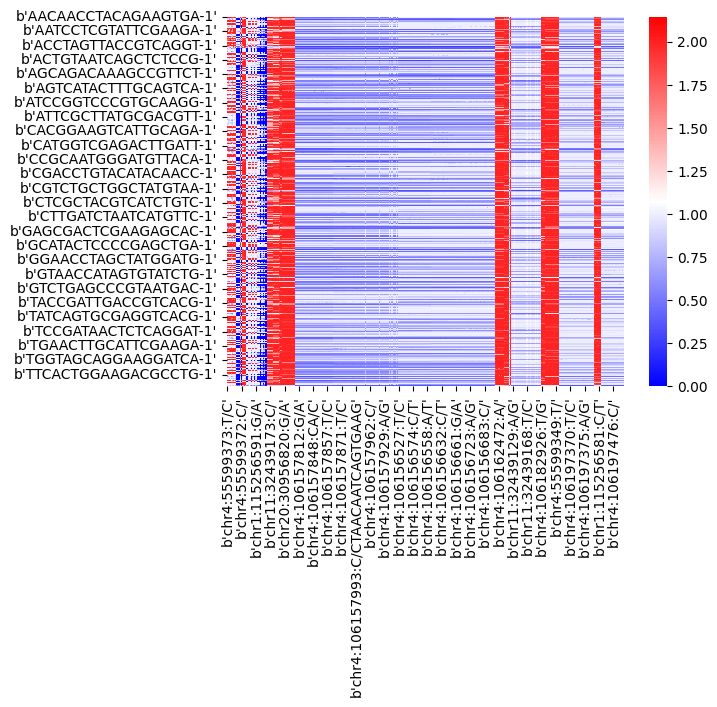

In [58]:
sns.heatmap(top1000_var, cmap="bwr")

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


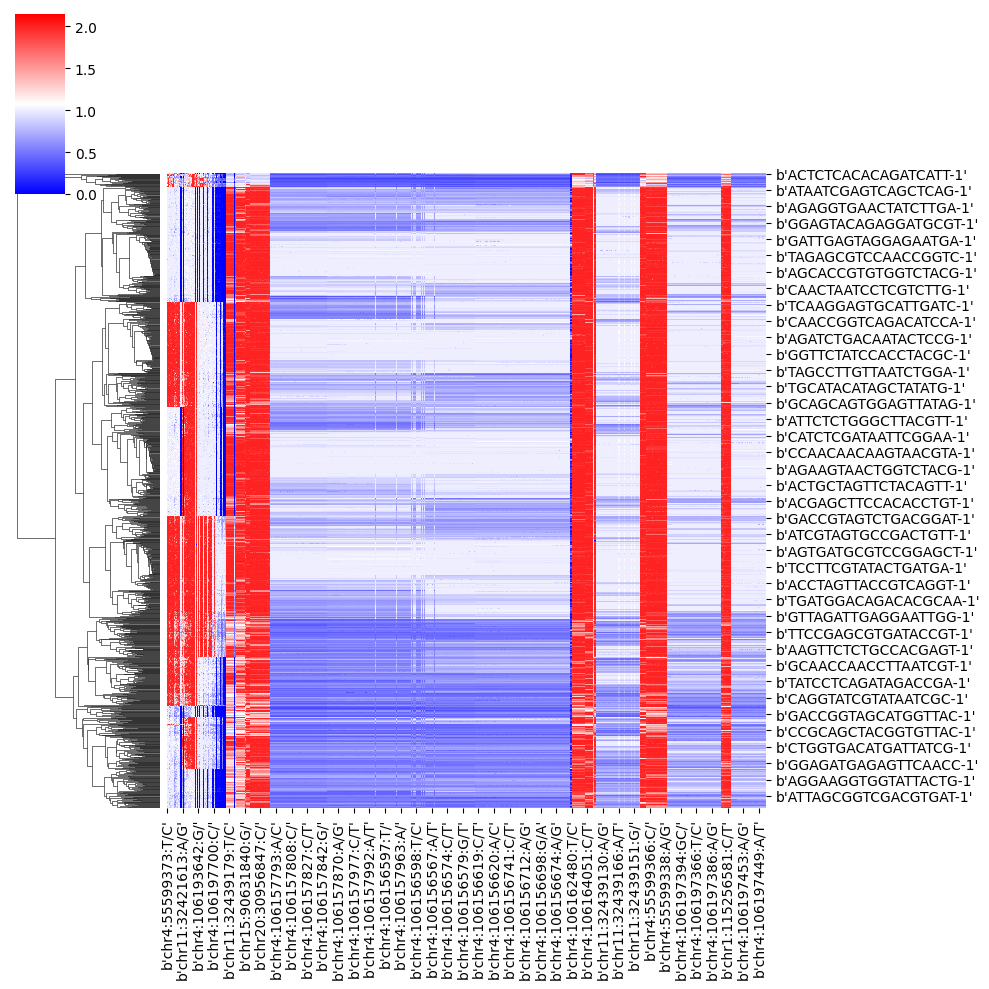

In [59]:
sns.clustermap(top1000_var, cmap="bwr",col_cluster=False ) # vafs by hand 

In [60]:
vafs_corrected = vafs_corrected.dropna(axis=1)
top1000_var = vafs_corrected[vafs_corrected.std().sort_values(ascending=False).iloc[:1000].index]
top1000_var

b'chr4:106194275:T/C'  b'chr4:106194109:T/C'   
b'AACAACCTACAGAAGTGA-1'               0.006211               0.000000  \
b'AACAACCTATCTATGACA-1'               0.015152               0.000000   
b'AACAACTGGCAACGCACA-1'               0.008271               0.000000   
b'AACACACTCTTACAGTGT-1'               0.010989               0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.004456               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.015152               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.003043               0.000316   
b'TTGGTAACTTCTGCGCTG-1'               0.055556               0.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.004167               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.010000               0.000000   

                         b'chr4:106194146:T/C'  b'chr4:106194073:C/T'   
b'AACAACCTACAGAAGTGA-1'                0.00000                    0.0  \
b'AACAACCTATCTATGACA-1'                0.00000                    0.0   
b'AACAACTGGCAACGCACA-1'                0.00000                    0.0   
b'AACACACTCTTACAGTGT-1'                0.00000                    0.0   
b'AACAGCAGTCGTCTGCTG-1'                0.00000                    0.0   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                0.00000                    0.0   
b'TTGGAGAACTGAACTTGC-1'                0.00026                    0.0   
b'TTGGTAACTTCTGCGCTG-1'                0.00000                    0.0   
b'TTGTCAACCGCAGCAGTG-1'                0.00000                    0.0   
b'TTGTTAGAGAATCTCCTA-1'                0.00000                    0.0   

                         b'chr4:106194245:A/G'  b'chr4:106194169:T/C'   
b'AACAACCTACAGAAGTGA-1'               0.001976               0.003953  \
b'AACAACCTATCTATGACA-1'               0.000000               0.000000   
b'AACAACTGGCAACGCACA-1'               0.000000               0.000000   
b'AACACACTCTTACAGTGT-1'               0.001479               0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.000865               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000               0.000000   
b'TTGGAGAACTGAACTTGC-1'               0.000260               0.000000   
b'TTGGTAACTTCTGCGCTG-1'               0.010000               0.000000   
b'TTGTCAACCGCAGCAGTG-1'               0.000595               0.000000   
b'TTGTTAGAGAATCTCCTA-1'               0.000000               0.000000   

                         b'chr20:31023419:T/C'  b'chr4:106194212:A/G'   
b'AACAACCTACAGAAGTGA-1'                    0.0               0.000000  \
b'AACAACCTATCTATGACA-1'                    0.0               0.000000   
b'AACAACTGGCAACGCACA-1'                    0.0               0.000693   
b'AACACACTCTTACAGTGT-1'                    0.0               0.000000   
b'AACAGCAGTCGTCTGCTG-1'                    0.0               0.000000   
...                                        ...                    ...   
b'TTGGACTTCCGCTTATGA-1'                    0.0               0.000000   
b'TTGGAGAACTGAACTTGC-1'                    0.0               0.000000   
b'TTGGTAACTTCTGCGCTG-1'                    0.0               0.000000   
b'TTGTCAACCGCAGCAGTG-1'                    0.0               0.000000   
b'TTGTTAGAGAATCTCCTA-1'                    0.0               0.002000   

                         b'chr4:106194123:T/C'  b'chr20:31023428:T/C'  ...   
b'AACAACCTACAGAAGTGA-1'                    0.0                    0.0  ...  \
b'AACAACCTATCTATGACA-1'                    0.0                    0.0  ...   
b'AACAACTGGCAACGCACA-1'                    0.0                    0.0  ...   
b'AACACACTCTTACAGTGT-1'                    0.0                    0.0  ...   
b'AACAGCAGTCGTCTGCTG-1'                    0.0                    0.0  ...   
...                                        ...   

<Axes: >

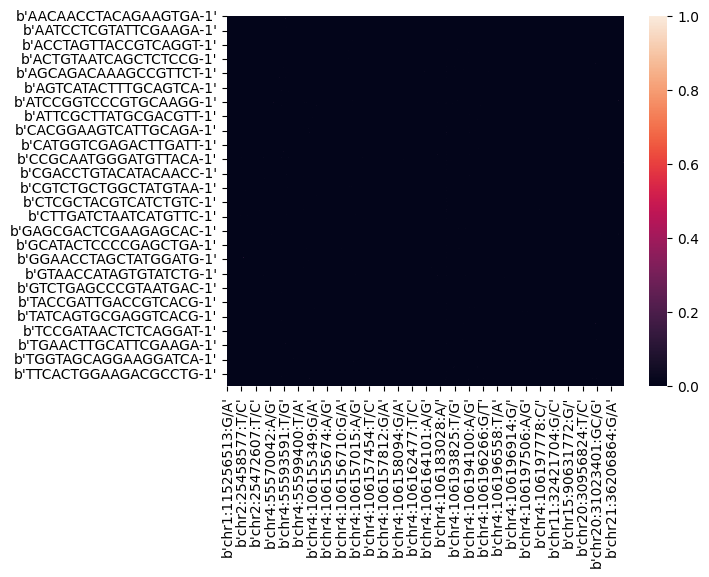

In [62]:
sns.heatmap(vafs_corrected)

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


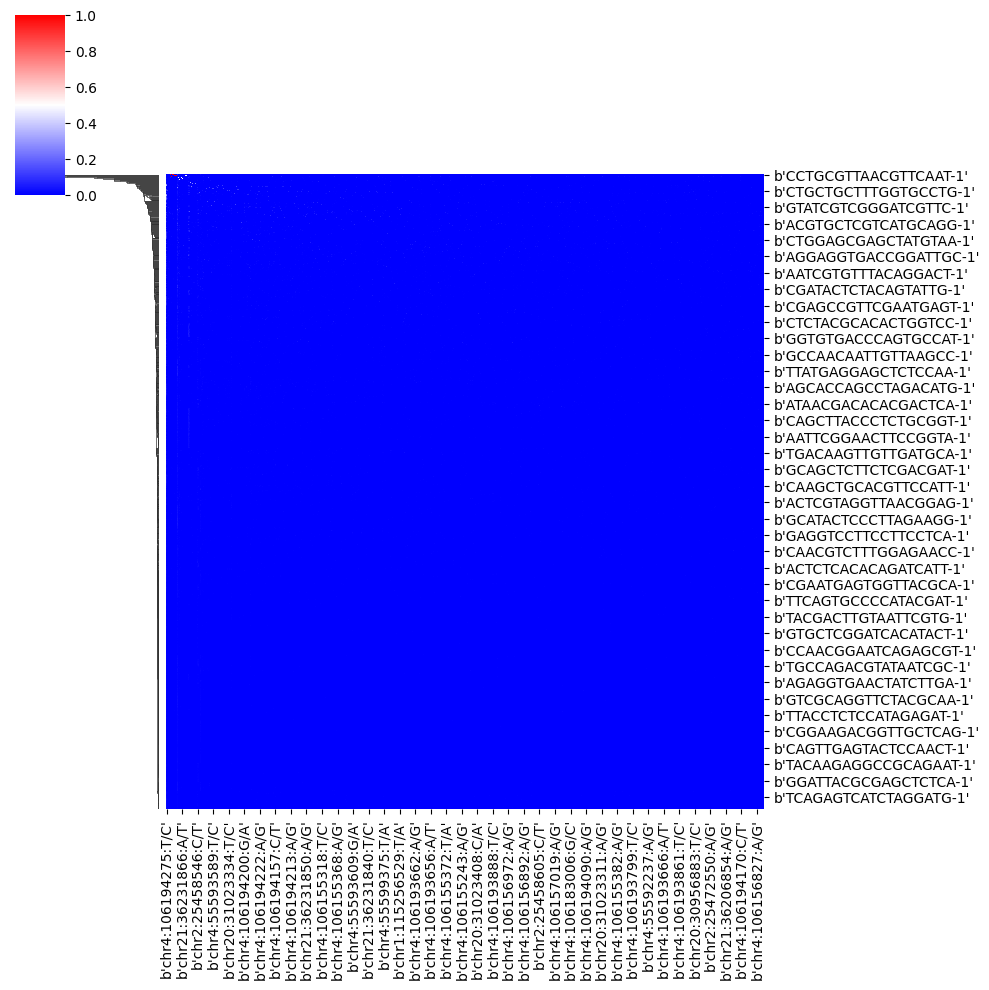

In [61]:
sns.clustermap(top1000_var, cmap="bwr",col_cluster=False ) # corrected vafs

In [65]:
# no nan in vafs
top1000_var = vafs[vafs.std().sort_values(ascending=False).iloc[:1000].index]
top1000_var

b'chr9:5073770:G/T'  b'chr7:148504906:*/T+TA'   
b'AACAACCTACAGAAGTGA-1'                  1.0                  1.000000  \
b'AACAACCTATCTATGACA-1'                  0.0                  0.000000   
b'AACAACTGGCAACGCACA-1'                  1.0                  0.000000   
b'AACACACTCTTACAGTGT-1'                  0.0                  0.962963   
b'AACAGCAGTCGTCTGCTG-1'                  0.0                  0.000000   
...                                      ...                       ...   
b'TTGGACTTCCGCTTATGA-1'                  0.0                  0.000000   
b'TTGGAGAACTGAACTTGC-1'                  0.0                  0.982456   
b'TTGGTAACTTCTGCGCTG-1'                  0.0                  0.000000   
b'TTGTCAACCGCAGCAGTG-1'                  0.0                  1.000000   
b'TTGTTAGAGAATCTCCTA-1'                  0.0                  0.979592   

                         b'chr17:7580052:C/T'  b'chr3:128200806:G/A'   
b'AACAACCTACAGAAGTGA-1'              0.000000                0.03125  \
b'AACAACCTATCTATGACA-1'              0.000000                0.00000   
b'AACAACTGGCAACGCACA-1'              0.000000                0.00000   
b'AACACACTCTTACAGTGT-1'              0.428571                1.00000   
b'AACAGCAGTCGTCTGCTG-1'              0.000000                0.00000   
...                                       ...                    ...   
b'TTGGACTTCCGCTTATGA-1'              0.000000                0.00000   
b'TTGGAGAACTGAACTTGC-1'              1.000000                1.00000   
b'TTGGTAACTTCTGCGCTG-1'              1.000000                1.00000   
b'TTGTCAACCGCAGCAGTG-1'              1.000000                0.96000   
b'TTGTTAGAGAATCTCCTA-1'              1.000000                1.00000   

                         b'chr17:7578523:T/TG'  b'chr4:106154990:TATAGATAG/T'   
b'AACAACCTACAGAAGTGA-1'               0.000000                       0.900000  \
b'AACAACCTATCTATGACA-1'               0.000000                       0.357143   
b'AACAACTGGCAACGCACA-1'               0.000000                       1.000000   
b'AACACACTCTTACAGTGT-1'               0.588235                       0.000000   
b'AACAGCAGTCGTCTGCTG-1'               0.062500                       0.370370   
...                                        ...                            ...   
b'TTGGACTTCCGCTTATGA-1'               0.000000                       0.000000   
b'TTGGAGAACTGAACTTGC-1'               1.000000                       0.212121   
b'TTGGTAACTTCTGCGCTG-1'               1.000000                       0.333333   
b'TTGTCAACCGCAGCAGTG-1'               1.000000                       0.312500   
b'TTGTTAGAGAATCTCCTA-1'               1.000000                       0.666667   

                         b'chr4:106154998:GATA/G'  b'chr4:106154995:A/ATAGG'   
b'AACAACCTACAGAAGTGA-1'                  0.000000                   0.900000  \
b'AACAACCTATCTATGACA-1'                  0.357143                   0.357143   
b'AACAACTGGCAACGCACA-1'                  1.000000                   1.000000   
b'AACACACTCTTACAGTGT-1'                  0.111111                   0.111111   
b'AACAGCAGTCGTCTGCTG-1'                  0.400000                   0.400000   
...                                           ...                        ...   
b'TTGGACTTCCGCTTATGA-1'                  1.000000                   1.000000   
b'TTGGAGAACTGAACTTGC-1'                  0.212121                   0.212121   
b'TTGGTAACTTCTGCGCTG-1'                  0.352941                   0.352941   
b'TTGTCAACCGCAGCAGTG-1'                  0.312500                   0.312500   
b'TTGTTAGAGAATCTCCTA-1'                  0.666667                   0.666667   

                         b'chr4:106154997:A/G'  b'chr4:106154998:GATAGATA/*'   
b'AACAACCTACAGAAGTGA-1'               0.900000                      0.818182  \
b'AACAACCTATCTATGACA-1'               0.357143                      0.357143   
b'AACAACTGGCAACGCACA-1'               1.000000                      1.000000   
b'AACACACTCTTACAG

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


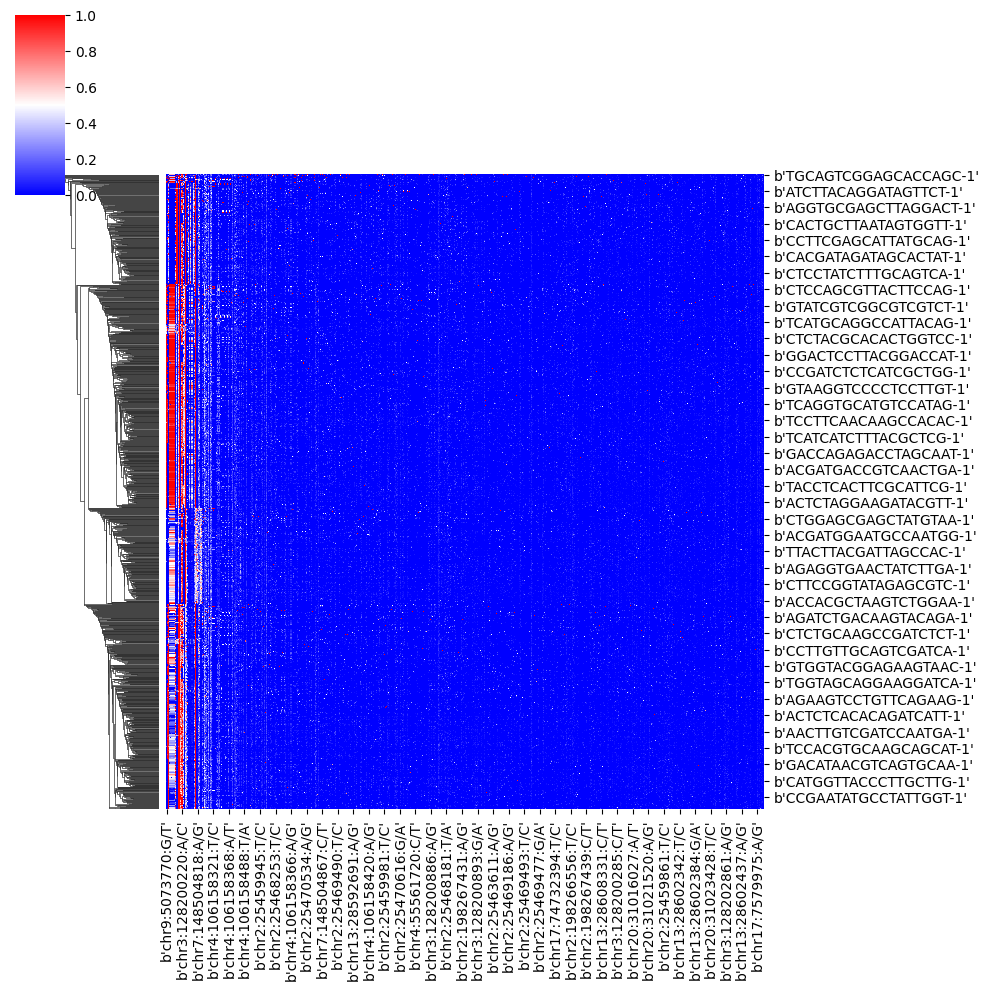

In [66]:
sns.clustermap(top1000_var, cmap="bwr",col_cluster=False ) # vafs

## CNA amplicon

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


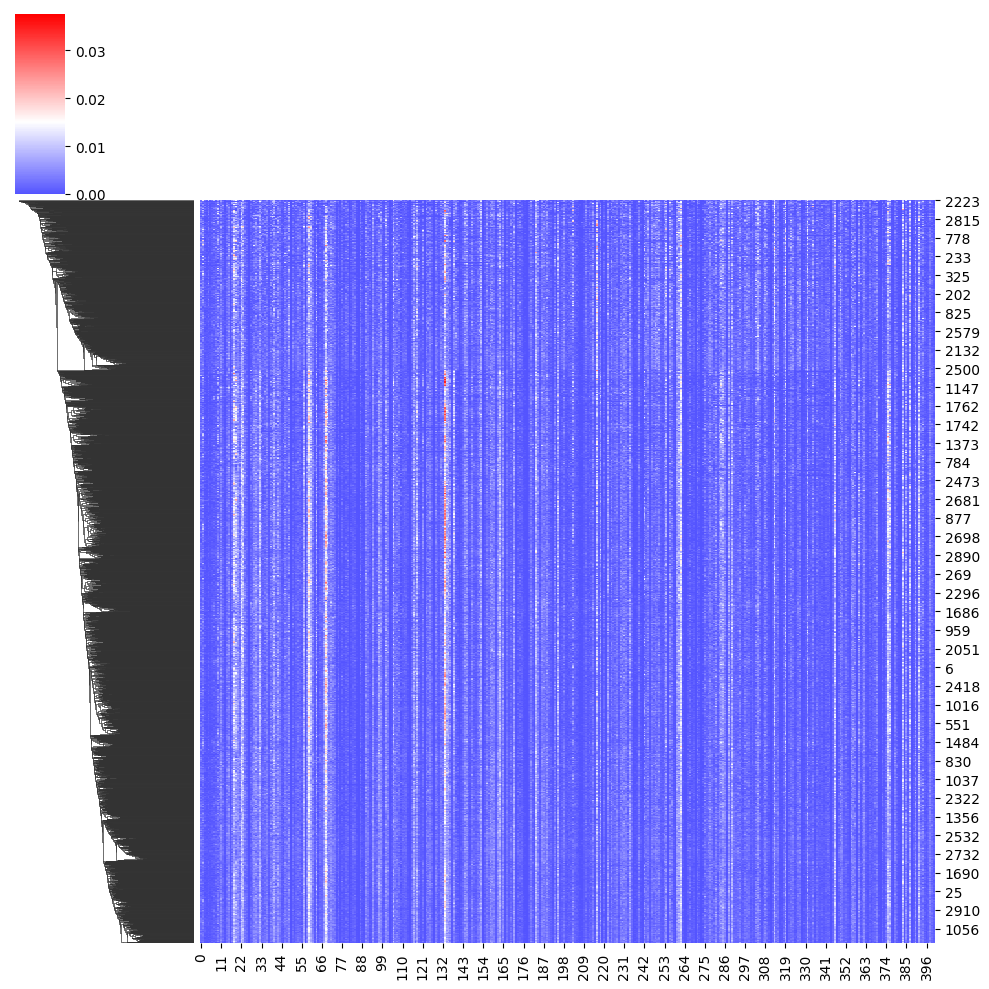

In [33]:
sns.clustermap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), col_cluster=False, cmap="bwr", center = 0.015) # cluster after normalization

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


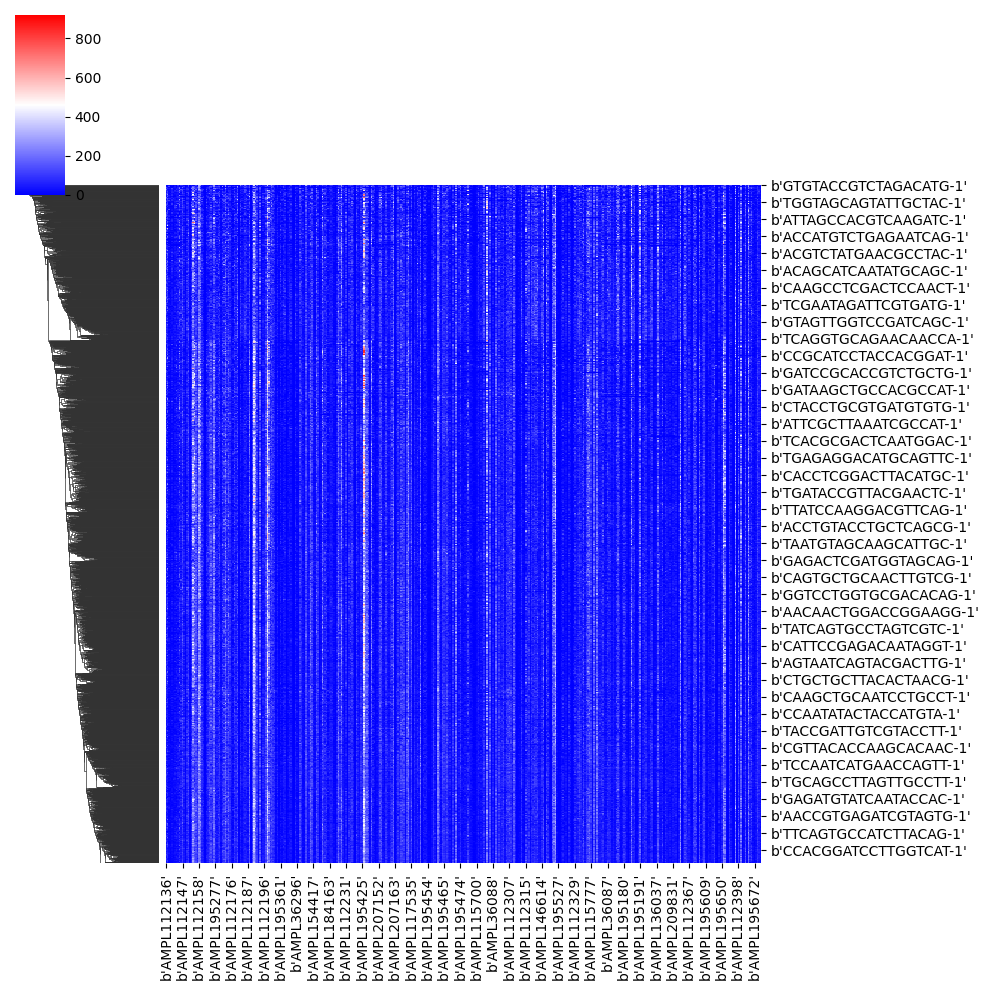

In [34]:
mean_tot_nb_read_cell = read_counts.sum(axis=1).mean()
sns.clustermap(read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)*mean_tot_nb_read_cell, col_cluster=False, cmap="bwr") # cluster after normalization and new magnitude

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


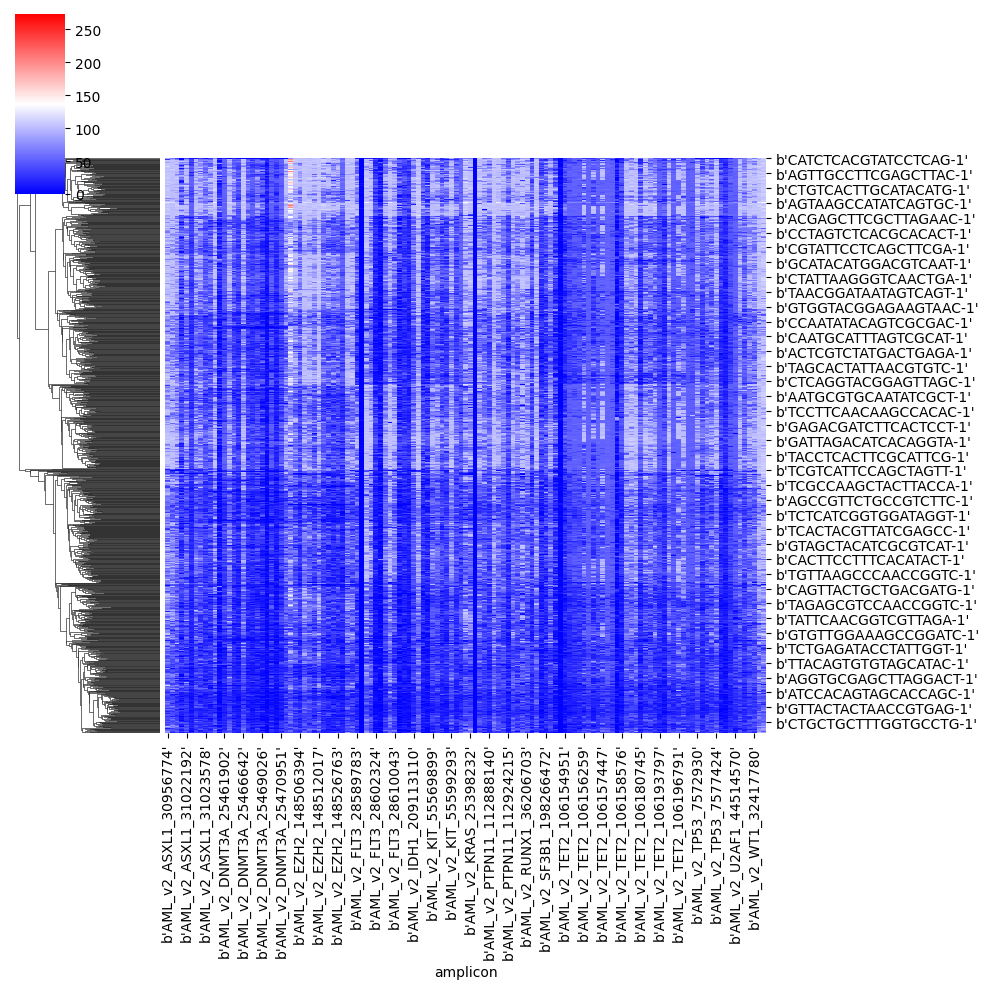

In [69]:
sns.clustermap(max_amplicon, col_cluster=False, cmap="bwr") # cluster when read count = max read count of variant for amplicon and cell

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


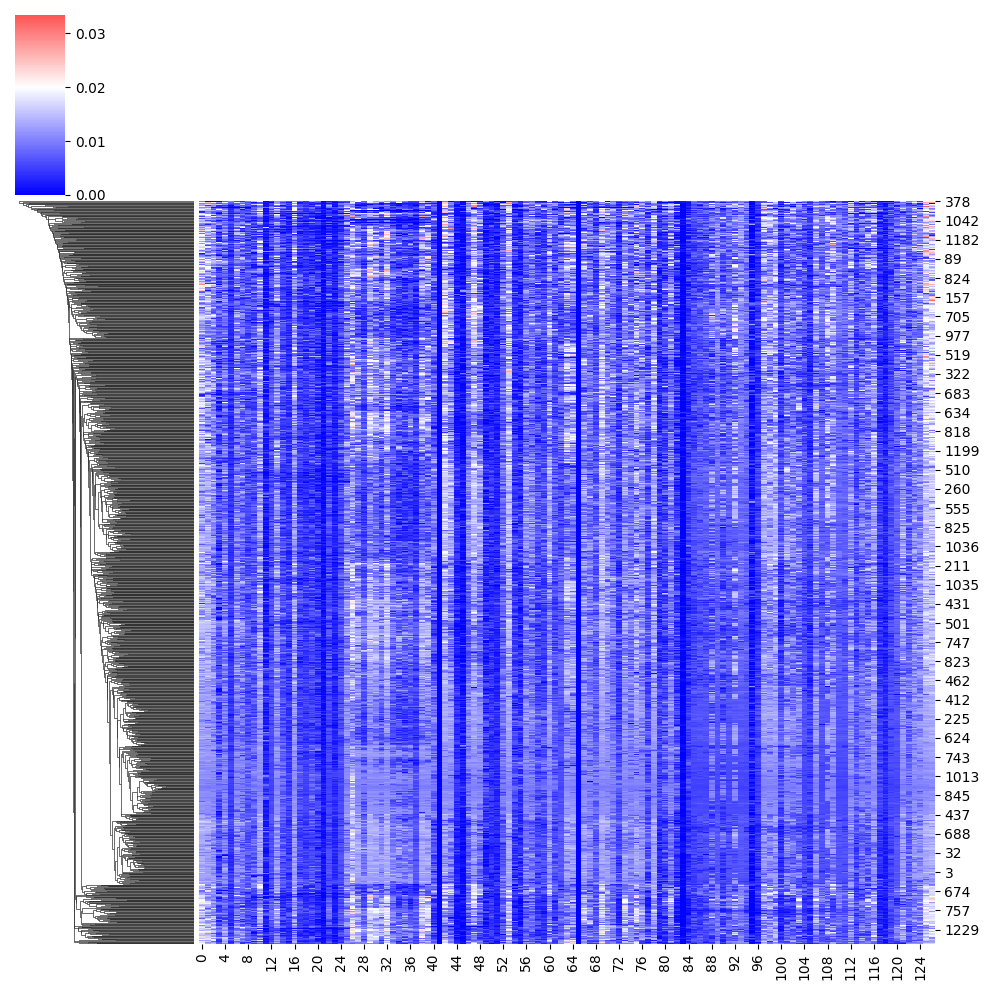

In [71]:
sns.clustermap((max_amplicon.apply(lambda x : x/max_amplicon.sum(axis=1), axis=0)).to_numpy(), col_cluster=False, cmap="bwr",center = 0.02) # same but after normalization

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


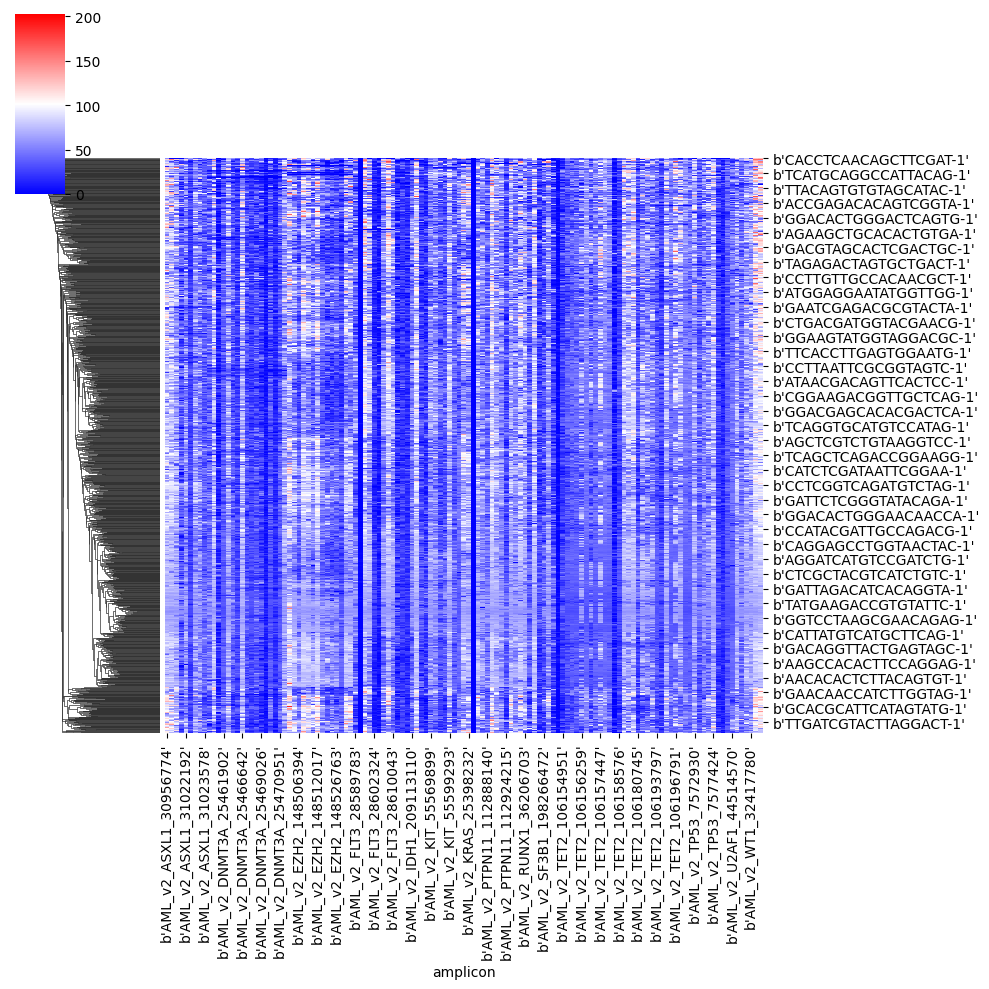

In [81]:
mean_tot_nb_read_cell = max_amplicon.sum(axis=1).mean()
sns.clustermap(max_amplicon.apply(lambda x : x/max_amplicon.sum(axis=1), axis=0)*mean_tot_nb_read_cell, col_cluster=False, cmap="bwr") # same after change in magnitude

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
normalized_data = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy()

linkage_data = linkage(normalized_data, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

In [35]:
clusters = fcluster(linkage_data, t=0.3 , criterion='distance')

In [44]:
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(normalized_data)

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(normalized_data)

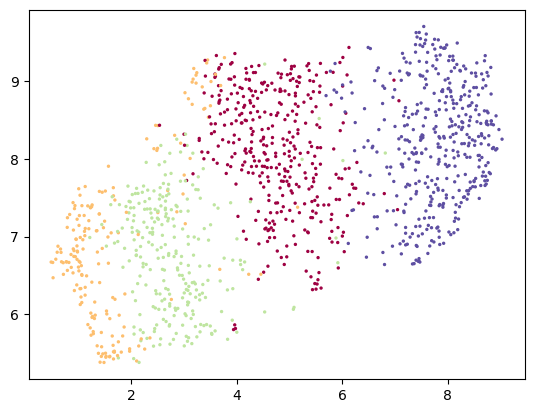

In [56]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=2, cmap ='Spectral')

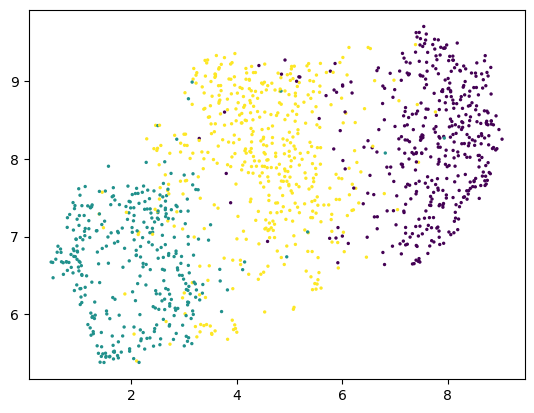

In [57]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clusters, s=2)

In [58]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(normalized_data)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fillpattern': {'shape': ''},
              'hovertemplate': '# Components=%{x}<br>Explained Variance=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'stackgroup': '1',
              'type': 'scatter',
              'x': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
                           15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
                           29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
                           43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
                           57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
                           71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
                           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
                          113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
                          127], dtype=int64),
              'xaxis': 'x',
              'y': array([0.16431526, 0.22268661, 0.26733163, 0.3062504 , 0.33729686, 0.36547652,
                          0.38740197, 0.40636245, 0.42269184, 0.43722626, 0.45086957, 0.46429161,
                          0.47707301, 0.48946263, 0.50159836, 0.51287154, 0.52368253, 0.53414171,
                          0.54439541, 0.55452084, 0.56429787, 0.57361048, 0.58281873, 0.59171856,
                          0.60048736, 0.60909364, 0.61764012, 0.62598622, 0.63403914, 0.64207155,
                          0.64987395, 0.65759156, 0.66509934, 0.67239094, 0.67964621, 0.68669999,
                          0.69363758, 0.70034525, 0.70700535, 0.71348707, 0.71993262, 0.72619737,
                          0.73243223, 0.7386253 , 0.74465202, 0.75065711, 0.75651366, 0.76224577,
                          0.76789011, 0.77347096, 0.77887593, 0.78425205, 0.78945634, 0.79456998,
                          0.79965927, 0.80468713, 0.8096729 , 0.81452613, 0.81929967, 0.82402433,
                          0.82871399, 0.83330742, 0.83780238, 0.84224401, 0.84666758, 0.85098697,
                          0.85522374, 0.85936612, 0.86347748, 0.86750001, 0.87148204, 0.87542158,
                          0.87931229, 0.88310279, 0.88682229, 0.89053591, 0.89415568, 0.89772922,
                          0.90122402, 0.90470386, 0.90812833, 0.91146886, 0.91473454, 0.91795909,
                          0.92113944, 0.92428743, 0.92735257, 0.93040975, 0.93334783, 0.93622116,
                          0.93907665, 0.94186338, 0.94461336, 0.94729911, 0.94990411, 0.95244029,
                          0.95495732, 0.95737901, 0.95972253, 0.96206044, 0.96426573, 0.96644613,
                          0.96858334, 0.97063383, 0.97265286, 0.97461894, 0.97658145, 0.97847935,
                          0.98036716, 0.98223984, 0.9840071 , 0.98570591, 0.98737283, 0.98901257,
                          0.99058002, 0.99203296, 0.99346144, 0.99477663, 0.99605776, 0.99728379,
                          0.99823744, 0.99908547, 0.99956115, 0.9999829 , 1.        , 1.        ,
                          1.        ]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': '# Components'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Explained Variance'}}}
})

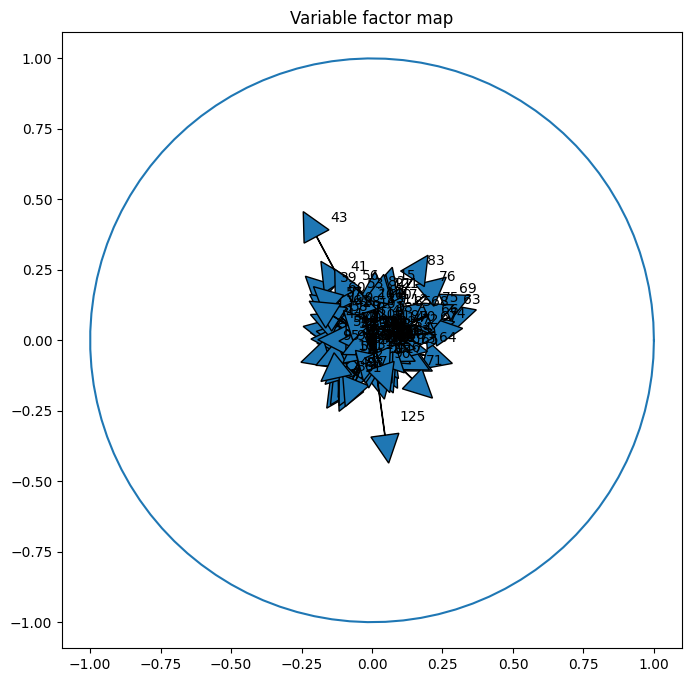

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 

 
n_components = 80 #scaled.shape[1]
 
# Do the PCA.
pca = PCA(n_components=n_components)
pca.fit_transform(np.copy(normalized_data))


# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             i)


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

SNV info 

- 43 : TET2
- 125 : U2AF1

In [63]:
amplicons.iloc[43]

CHROM                            b'4'
end_pos                     106158015
id           b'AML_v2_TET2_106157777'
r1_counts                       90216
r2_counts                       90230
start_pos                   106157757
Name: 43, dtype: object

In [64]:
amplicons.iloc[125]

CHROM                           b'21'
end_pos                      44514808
id           b'AML_v2_U2AF1_44514570'
r1_counts                       65367
r2_counts                       65269
start_pos                    44514550
Name: 125, dtype: object

# Ridgeline

In [36]:
normalized_read = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).T
#normalized_read['amplicon'] = normalized_read.index

In [34]:
normalized_read

b'AACAACCTACAGAAGTGA-1'  b'AACAACCTATCTATGACA-1'   
b'AML_v2_NRAS_115256512'                  0.008457                 0.003744  \
b'AML_v2_NRAS_115258635'                  0.006857                 0.006467   
b'AML_v2_DNMT3A_25457166'                 0.005257                 0.008509   
b'AML_v2_DNMT3A_25458540'                 0.009143                 0.007488   
b'AML_v2_DNMT3A_25459813'                 0.004571                 0.001702   
...                                            ...                      ...   
b'AML_v2_RUNX1_36206703'                  0.007771                 0.011913   
b'AML_v2_RUNX1_36231714'                  0.007543                 0.011232   
b'AML_v2_RUNX1_36252844'                  0.010286                 0.011572   
b'AML_v2_U2AF1_44514570'                  0.012114                 0.015997   
b'AML_v2_U2AF1_44524438'                  0.006857                 0.008850   

                           b'AACAACTGGCAACGCACA-1'  b'AACACACTCTTACAGTGT-1'   
b'AML_v2_NRAS_115256512'                  0.013091                 0.013604  \
b'AML_v2_NRAS_115258635'                  0.007736                 0.007148   
b'AML_v2_DNMT3A_25457166'                 0.002975                 0.005073   
b'AML_v2_DNMT3A_25458540'                 0.006843                 0.010145   
b'AML_v2_DNMT3A_25459813'                 0.007438                 0.001614   
...                                            ...                      ...   
b'AML_v2_RUNX1_36206703'                  0.005951                 0.010837   
b'AML_v2_RUNX1_36231714'                  0.002678                 0.004381   
b'AML_v2_RUNX1_36252844'                  0.010711                 0.010606   
b'AML_v2_U2AF1_44514570'                  0.010414                 0.014526   
b'AML_v2_U2AF1_44524438'                  0.007736                 0.010606   

                           b'AACAGCAGTCGTCTGCTG-1'  b'AACAGCAGTGATGCTCCT-1'   
b'AML_v2_NRAS_115256512'                  0.006147                 0.010802  \
b'AML_v2_NRAS_115258635'                  0.006345                 0.005492   
b'AML_v2_DNMT3A_25457166'                 0.008328                 0.006957   
b'AML_v2_DNMT3A_25458540'                 0.014674                 0.010619   
b'AML_v2_DNMT3A_25459813'                 0.001785                 0.000915   
...                                            ...                      ...   
b'AML_v2_RUNX1_36206703'                  0.007932                 0.007689   
b'AML_v2_RUNX1_36231714'                  0.007139                 0.003662   
b'AML_v2_RUNX1_36252844'                  0.012294                 0.007689   
b'AML_v2_U2AF1_44514570'                  0.012096                 0.009703   
b'AML_v2_U2AF1_44524438'                  0.007932                 0.008971   

                           b'AACCGCTGAAACAACCTA-1'  b'AACCGCTGAACCACGCTA-1'   
b'AML_v2_NRAS_115256512'                  0.006612                 0.008097  \
b'AML_v2_NRAS_115258635'                  0.012909                 0.007422   
b'AML_v2_DNMT3A_25457166'                 0.005982                 0.006973   
b'AML_v2_DNMT3A_25458540'                 0.009761                 0.014395   
b'AML_v2_DNMT3A_25459813'                 0.000315                 0.003599   
...                                            ...                      ...   
b'AML_v2_RUNX1_36206703'                  0.005982                 0.006523   
b'AML_v2_RUNX1_36231714'                  0.005982                 0.003599   
b'AML_v2_RUNX1_36252844'                  0.009446                 0.011021   
b'AML_v2_U2AF1_44514570'                  0.009446                 0.019793   
b'AML_v2_U2AF1_44524438'                  0.005982                 0.007422   

                           b'AACGCATTGCGTTAATGG-1'  b'AACGCCTACACCATACTT-1'   
b'AML_v2_NRAS_115256512'                  0.009553                 0.008205  \
b'AML_v2_NRAS_115258635'                  0.009834                 0.0080

In [37]:
data_facetgrid = normalized_read.stack().reset_index(level=1,drop=True).to_frame()
data_facetgrid['amplicon'] = data_facetgrid.index
data_facetgrid

0                  amplicon
b'AML_v2_NRAS_115256512'  0.008457  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.003744  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.013091  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.013604  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.006147  b'AML_v2_NRAS_115256512'
...                            ...                       ...
b'AML_v2_U2AF1_44524438'  0.008320  b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438'  0.010275  b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438'  0.009309  b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438'  0.009930  b'AML_v2_U2AF1_44524438'
b'AML_v2_U2AF1_44524438'  0.010784  b'AML_v2_U2AF1_44524438'

[157480 rows x 2 columns]

In [49]:
data_facetgrid.iloc[:2480]

0                  amplicon
b'AML_v2_NRAS_115256512'  0.008457  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.003744  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.013091  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.013604  b'AML_v2_NRAS_115256512'
b'AML_v2_NRAS_115256512'  0.006147  b'AML_v2_NRAS_115256512'
...                            ...                       ...
b'AML_v2_NRAS_115258635'  0.002080  b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635'  0.000112  b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635'  0.009723  b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635'  0.008688  b'AML_v2_NRAS_115258635'
b'AML_v2_NRAS_115258635'  0.012153  b'AML_v2_NRAS_115258635'

[2480 rows x 2 columns]

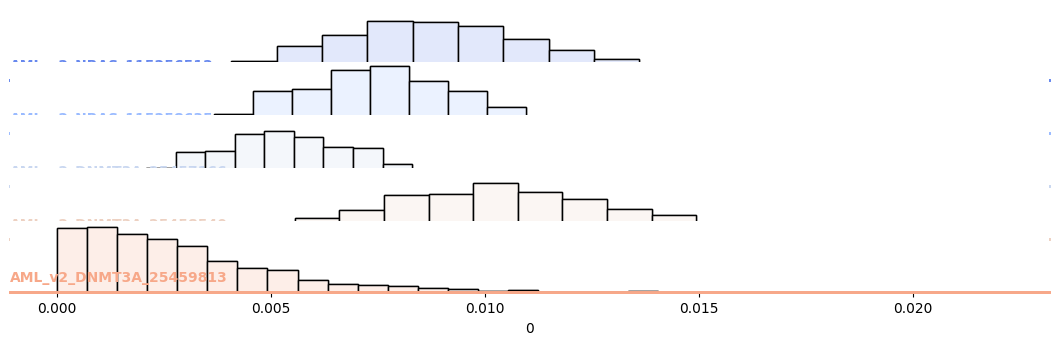

In [42]:
# we generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm')

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
g = sns.FacetGrid(data_facetgrid.iloc[:6200], row='amplicon' , hue='amplicon', aspect=15, height=0.75, palette=pal)

# then we add the densities kdeplots for each month
g.map(sns.histplot, 0,
      fill=True, bins=20)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.histplot, 0, 
      bins=20, 
      color="w")
"""g.map(sns.kdeplot, 0,
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# here we add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, 0, 
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)"""

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 0)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)